In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import torch
from collections import defaultdict
from google.colab.patches import cv2_imshow
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd


In [ ]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118


In [ ]:
from PIL import Image
# root_dir = '../input/output-crns/CRNS_OUTPUT'
class HeightandWidth(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # Chargement des données à partir d'un fichier CSV
        self.root_dir = root_dir  # Répertoire racine contenant les images
        self.transform = transform  # Transformation à appliquer aux images

    def __len__(self):
        return len(self.data)  # Retourne la taille du dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  # Chemin d'accès à l'image
        print(img_name)
        image = cv2.imread(img_name)  # Lecture de l'image à l'aide de OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Conversion de l'espace de couleur de BGR à RGB

        label = self.data.iloc[idx, 1]  # Extraction de l'étiquette associée à l'image

        if self.transform:
            pic = self.transform(image)  # Application de la transformation spécifiée aux images

        return pic, label


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir l'image en objet de type PIL (Pillow)
    transforms.Resize((900, 700)),
    transforms.RandomRotation(10),  # Effectuer une rotation aléatoire de l'image dans la plage de -10 à +10 degrés
    transforms.ToTensor()  # Convertir l'image en tenseur PyTorch
])
#transforms.Resize((900, 700)),  # Redimensionner l'image à une taille spécifiée

In [ ]:
def train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    real_values = []  # To store real values
    predicted_values = []
    for inputs, labels in train_loader:
        #print("\n labels",labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels.unsqueeze_(dim=1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        #print("label float(train)",labels.float(),"outputs",outputs)
        loss = loss_fn(outputs, labels.float())
        real_values.extend(labels.float().tolist())
        predicted_values.extend(outputs.tolist())
        losses.append(loss.item())
       # Calcul des gradients, mise à jour des poids et réinitialisation des gradients à zéro
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    threshold = 0.25
    matches = (np.array(predicted_values) >= (np.array(real_values) - threshold)) & (np.array(predicted_values) <= (np.array(real_values) + threshold))
    matches_tensor = torch.from_numpy(matches.astype(int))
    correct_predictions += torch.sum(matches_tensor)
        # Calcul des gradients, mise à jour des poids et réinitialisation des gradients à zéro

    plt.scatter(real_values, predicted_values)
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title('Real Values vs Predicted Values(train)')
    plt.show()
    # Mise à jour du scheduler
    scheduler.step()

    # Calcul de la précision et de la perte moyenne
    return float(correct_predictions) / len(predicted_values), np.mean(losses)


In [ ]:
def eval_model(model, validation_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    real_values = []  # To store real values
    predicted_values = []

    for inputs, labels in validation_loader:

        inputs = inputs.to(device)
        #print("inputs :",inputs)
        labels = labels.to(device)
        labels.unsqueeze_(dim=1)
        outputs = model(inputs)

        #print('label_float(eval)',labels.float(),'  outputs  ',outputs)
        # Calcul des prédictions et de la perte
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels.float())
        real_values.extend(labels.float().tolist())
        predicted_values.extend(outputs.tolist())
        losses.append(loss.item())
        # Mise à jour des prédictions correctes et des pertes
    threshold = 0.25
    matches = (np.array(predicted_values) >= (np.array(real_values) - threshold)) & (np.array(predicted_values) <= (np.array(real_values) + threshold))
    matches_tensor = torch.from_numpy(matches.astype(int))
    correct_predictions += torch.sum(matches_tensor)
    plt.scatter(real_values, predicted_values)

    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title('Real Values vs Predicted Values(val)')
    plt.show()
    # Calcul de la précision et de la perte moyenne
    return float(correct_predictions) / len(predicted_values), np.mean(losses)


In [ ]:
def train_model(model, device, n_epochs=60):
    dataset = HeightandWidth(csv_file='/content/drive/MyDrive/olive/Tree_height.csv',
                          root_dir='/content/drive/MyDrive/olive/segmented/',
                          transform=transform)

    batch_size = 8
    validation_split = 0.2
    shuffle_dataset = True
    random_seed = 42

    # Obtention de la taille du jeu de données
    dataset_size = len(dataset)
    print("\n dataset_size",dataset_size)
    # Création de la liste des indices des échantillons
    indices = list(range(dataset_size))
    print("\n indices",indices)
    # Calcul de l'indice de séparation entre les ensembles d'entraînement et de validation
    split = int(np.floor(validation_split * dataset_size))
    print("\n split",split)

    # Mélange aléatoire des indices si shuffle_dataset est True
    if shuffle_dataset:
      np.random.seed(random_seed)
      np.random.shuffle(indices)

    # Division des indices en ensembles d'entraînement et de validation
    train_indices, val_indices = indices[split:], indices[:split]
    print("\n train_indices",train_indices)
    print("\n val_indices",val_indices)

    # Création des échantillonneurs pour les ensembles d'entraînement et de validation
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    print("\n train_sampler",train_sampler)
    print("\n valid_sampler",valid_sampler)

    # Création des chargeurs de données pour l'entraînement et la validation
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

    # Set requires_grad=False for all parameters initially
    save_dir = '/content/drive/MyDrive/olive/'
    weight_decay = 0
    #weight_decay = 0.001
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.6,weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.MSELoss()
    history = defaultdict(list)
    best_accuracy = 0
    best_train_loss=0
    best_test_loss=0
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        #print("train loader" ,len(train_loader))

        # Entraînement du modèle
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, len(train_loader))
        print(f'Train loss {train_loss}')
        print(f'train acc {train_acc}')
        # Évaluation du modèle sur les données de validation
        val_acc, val_loss = eval_model(model, validation_loader, loss_fn, device, len(validation_loader))
        print(f'Val loss {val_loss}')
        print(f'val acc {val_acc}')
        #print()
        torch.save(model.state_dict(), save_dir + 'resnet18_18_07_checkpointx.pth')
        # Enregistrement des métriques d'entraînement et de validation dans l'historique
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Sauvegarde du meilleur modèle basé sur la précision de validation
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
            best_train_loss=train_loss
            best_test_loss = val_loss
    epochs = range(1, len(history['train_loss']) + 1)

    plt.plot(epochs, history['train_loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training Loss vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(epochs, history['train_acc'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation Accuracy')
    plt.title('Training Accuracy vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print( "best_accuracy: ", best_accuracy)
    print("best_train_loss: ",best_train_loss)
    print("best_test_loss: ",best_test_loss)


    return model, history


In [ ]:
model18 = models.resnet34(pretrained=True)
print(model18.fc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.1MB/s]


Linear(in_features=512, out_features=1000, bias=True)


In [ ]:
num_features = model18.fc.in_features

print("Number of features:", num_features)

Number of features: 512


In [ ]:

for param in model18.parameters():
    # entrainer que final layer
    param.required_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model18.to(device)
#dropout_prob = 0.08  # Set the dropout probability
dropout_prob = 0
model18.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),  # Add dropout layer here
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),  # Add dropout layer here
    nn.Linear(64, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),  # Add dropout layer here
    nn.Linear(128, 1)
).to(device)


In [ ]:
from torchsummary import summary
# Print the summary of the model
summary(model18,input_size=(3,900, 700))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 450, 350]           9,408
       BatchNorm2d-2         [-1, 64, 450, 350]             128
              ReLU-3         [-1, 64, 450, 350]               0
         MaxPool2d-4         [-1, 64, 225, 175]               0
            Conv2d-5         [-1, 64, 225, 175]          36,864
       BatchNorm2d-6         [-1, 64, 225, 175]             128
              ReLU-7         [-1, 64, 225, 175]               0
            Conv2d-8         [-1, 64, 225, 175]          36,864
       BatchNorm2d-9         [-1, 64, 225, 175]             128
             ReLU-10         [-1, 64, 225, 175]               0
       BasicBlock-11         [-1, 64, 225, 175]               0
           Conv2d-12         [-1, 64, 225, 175]          36,864
      BatchNorm2d-13         [-1, 64, 225, 175]             128
             ReLU-14         [-1, 64, 2


 dataset_size 400

 indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

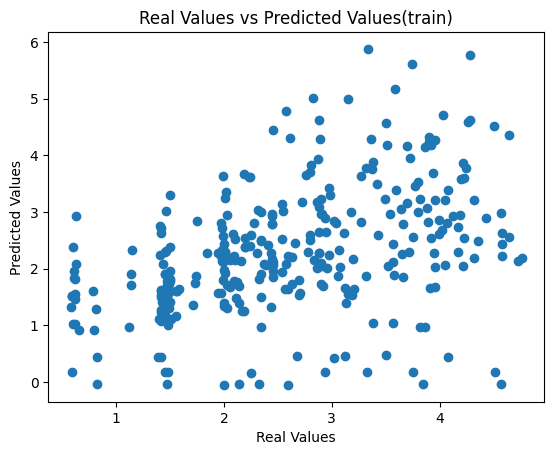

Train loss 1.4399649918079376
train acc 0.19375
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/s

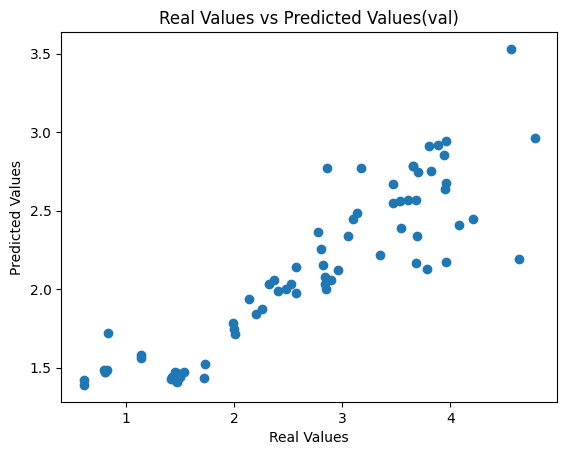

Val loss 0.7065702527761459
val acc 0.2625
Epoch 2/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_2.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/md2_1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_1.jpg
/content/drive/MyDrive/olive/segmented/md1_4.jpg
/content/drive/MyDrive/olive/segmented/im1_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_1.jpg
/content/drive/MyDrive/o

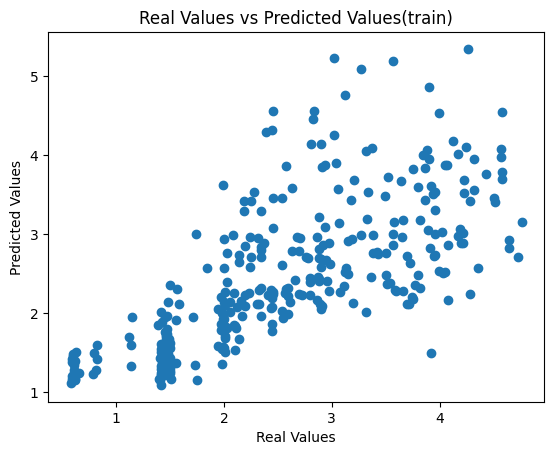

Train loss 0.594757650513202
train acc 0.315625
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.

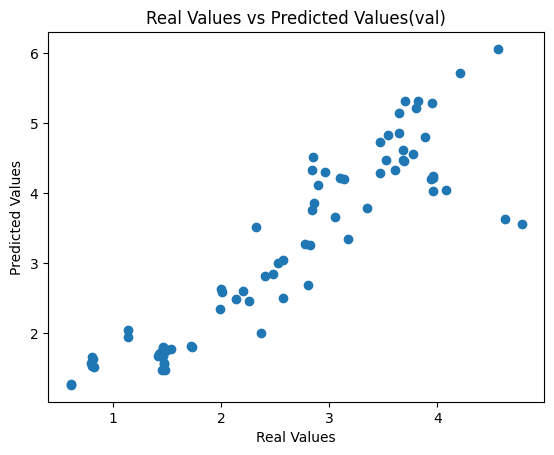

Val loss 0.6462000653147697
val acc 0.1875
Epoch 3/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_flip_6.jpg
/content/drive/MyDrive/olive/segmented/md3_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_2.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/md2_2_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_10.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_6.jpg
/content/drive/MyDrive/olive/segmented/md4_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_

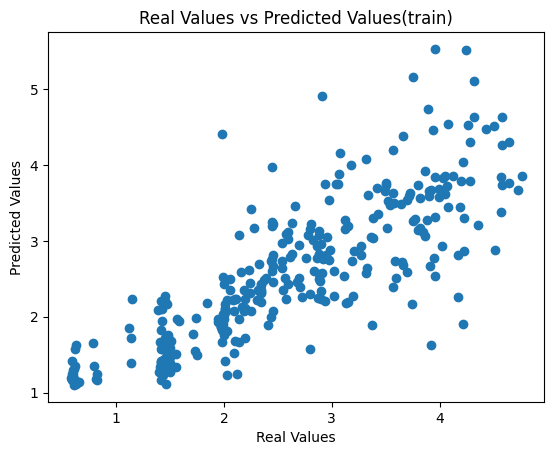

Train loss 0.3686853960156441
train acc 0.4375
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segm

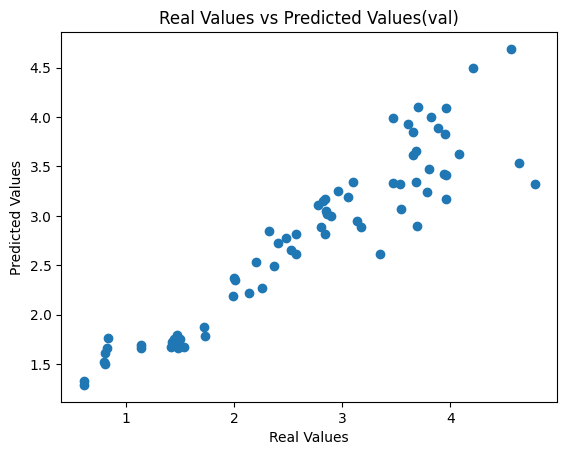

Val loss 0.18728165999054908
val acc 0.425
Epoch 4/60
----------
/content/drive/MyDrive/olive/segmented/im14_5_rotation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_5.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_translation_7.jpg
/content/drive/MyDrive/olive/segmented/md4_4_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056.jpg
/content/drive/MyDrive/olive/segmented/im14.jpg

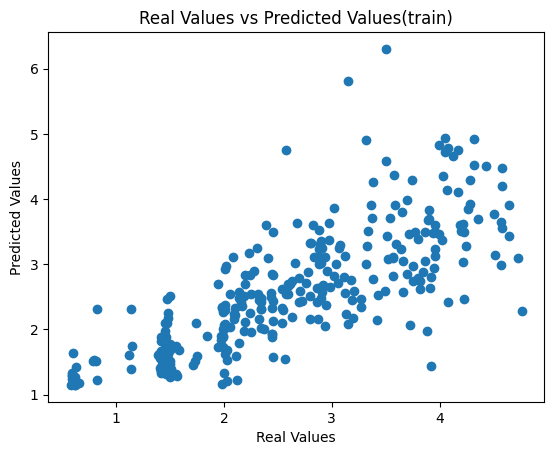

Train loss 0.45045993886888025
train acc 0.35625
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/My

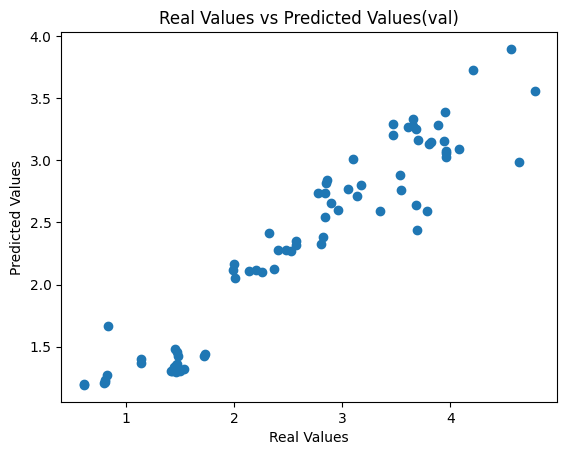

Val loss 0.26547206938266754
val acc 0.4625
Epoch 5/60
----------
/content/drive/MyDrive/olive/segmented/md4_5_translation_8.jpg
/content/drive/MyDrive/olive/segmented/md1_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_1_7.jpg
/content/drive/MyDrive/olive/segmented/md7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_1.jpg
/content/drive/MyDrive/olive/segmented/im8_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_1.jpg
/content/drive/MyDrive/olive/segmented/O_130123_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_1.jpg
/content/drive/MyDrive/olive/segment

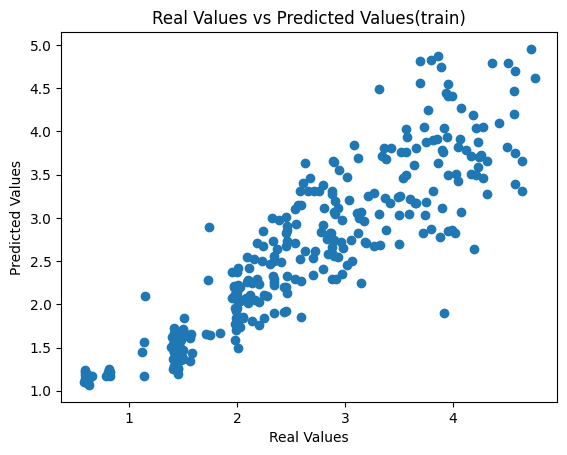

Train loss 0.21750249983742834
train acc 0.48125
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/dri

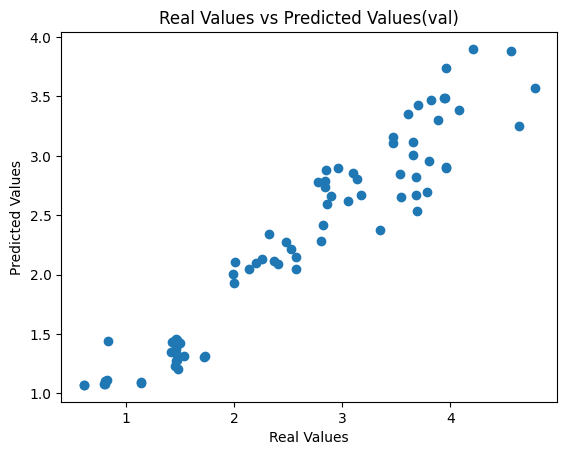

Val loss 0.24512165039777756
val acc 0.425
Epoch 6/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_1.jpg
/content/drive/MyDrive/olive/segmented/md1_6.jpg
/content/drive/MyDrive/olive/segmented/im7_1.jpg
/content/drive/MyDrive/olive/segmented/md1_4_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_2.jpg
/content/drive/MyDrive/olive/segmented/md2_4.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md4_2.jpg
/content/drive/MyDrive/olive/segmented/im6_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_3.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_5.jpg
/content/drive/MyDriv

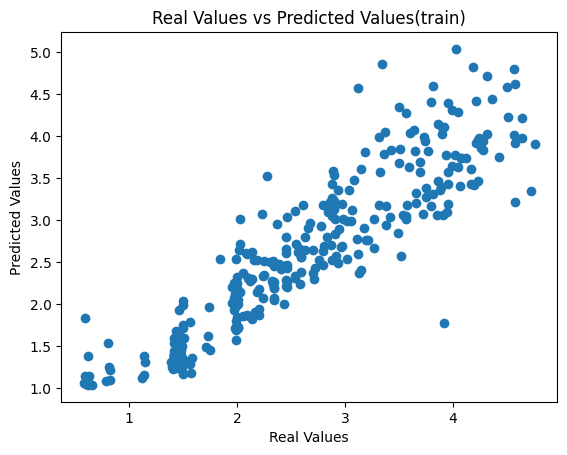

Train loss 0.18846624568104745
train acc 0.459375
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/oli

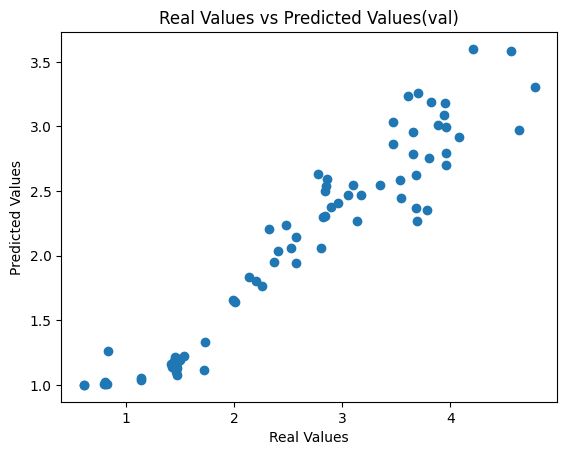

Val loss 0.443502676486969
val acc 0.125
Epoch 7/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_5.jpg
/content/drive/MyDrive/olive/segmented/im7_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_2.jpg
/content/drive/MyDrive/olive/segmented/O_125721_3.jpg
/content/drive/MyDrive/olive/segmented/im13_1.jpg
/content/drive/MyDrive/olive/segmented/im6_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_2.jpg
/content/drive/MyDrive/olive/segmented/O_124141.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_9.jpg
/content/drive/MyDrive/olive/segmented/md4_1.jpg
/content/drive/MyDrive/olive/segmented/im5_5.jpg
/content/dri

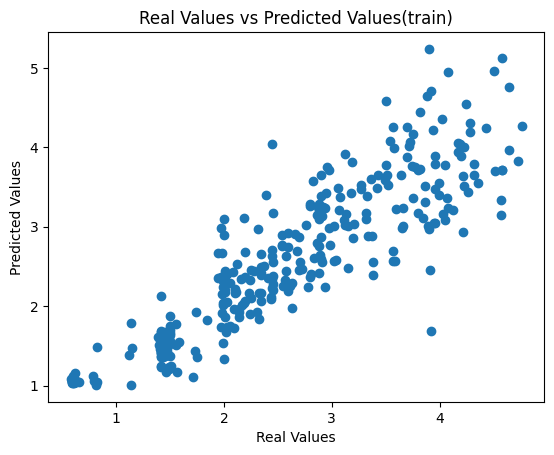

Train loss 0.23125436422415077
train acc 0.440625
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive

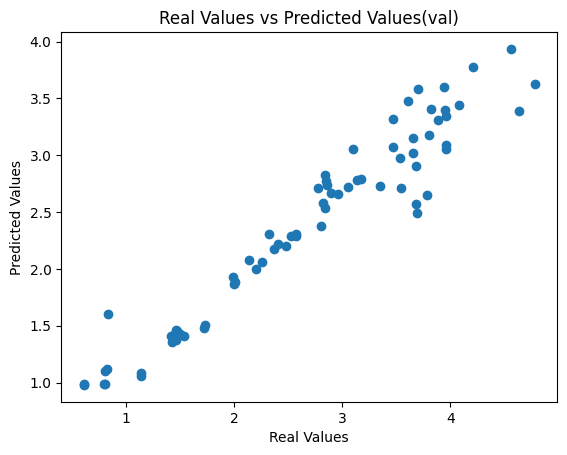

Val loss 0.20731379203498362
val acc 0.5375
Epoch 8/60
----------
/content/drive/MyDrive/olive/segmented/im12_2_8_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/O_124141_4.jpg
/content/drive/MyDrive/olive/segmented/im10.jpg
/content/drive/MyDrive/olive/segmented/md2_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_8.jpg
/content/drive/MyDrive/olive/segmented/md3_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624.jpg
/content/drive/MyDrive/olive/segmented/md

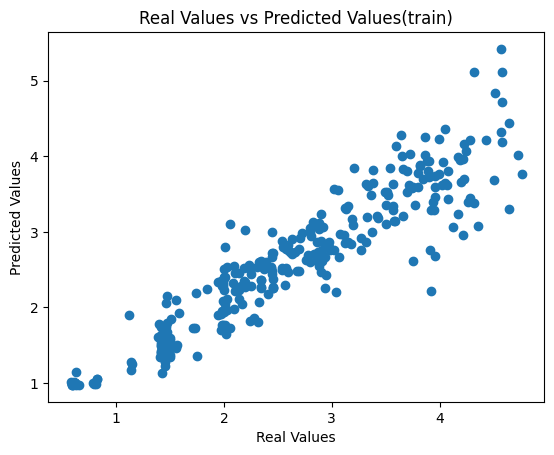

Train loss 0.1462375481147319
train acc 0.565625
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDri

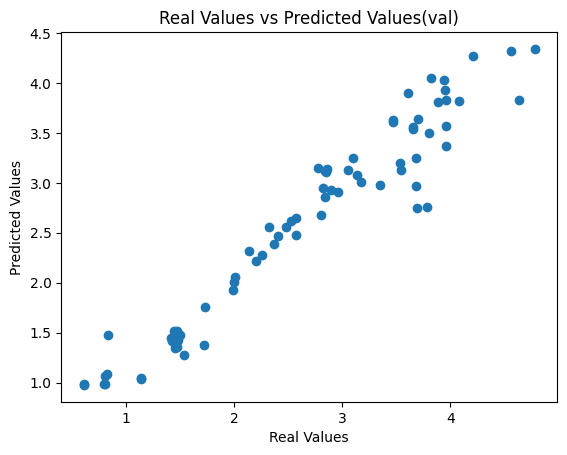

Val loss 0.08202949557453394
val acc 0.6875
Epoch 9/60
----------
/content/drive/MyDrive/olive/segmented/im7_2_9.jpg
/content/drive/MyDrive/olive/segmented/im8_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748.jpg
/content/drive/MyDrive/olive/segmented/md1_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_2.jpg
/content/drive/MyDrive/olive/segmented/O_131625_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_3.jpg
/content/drive/MyDrive/olive/segmented/im7_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_2022022

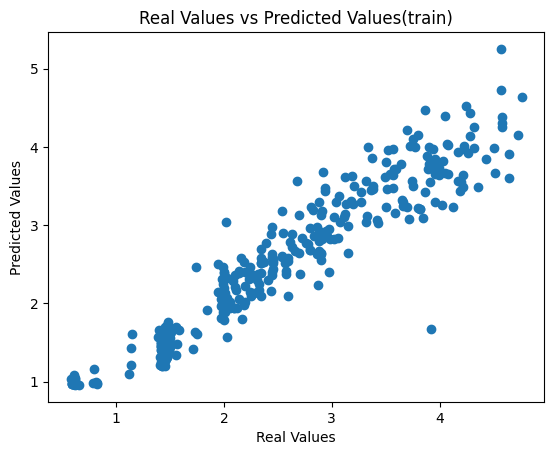

Train loss 0.11634450855199248
train acc 0.60625
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/d

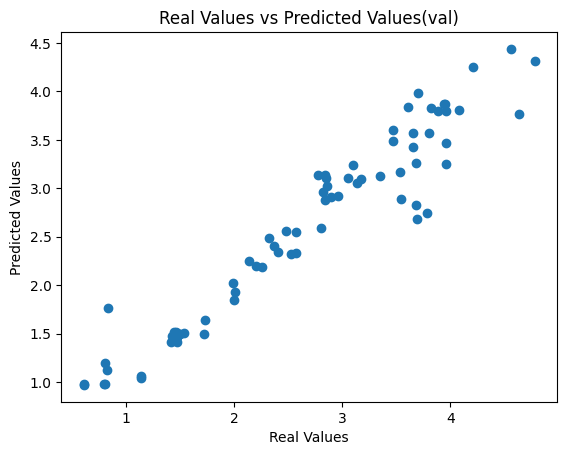

Val loss 0.09769257344305515
val acc 0.75
Epoch 10/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_1.jpg
/content/drive/MyDrive/olive/segmented/im9_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_1.jpg
/content/drive/MyDrive/olive/segmented/im11_1.jpg
/content/drive/MyDrive/olive/segmented/O_131625_1.jpg
/content/drive/MyDrive/olive/segmented/im13_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive

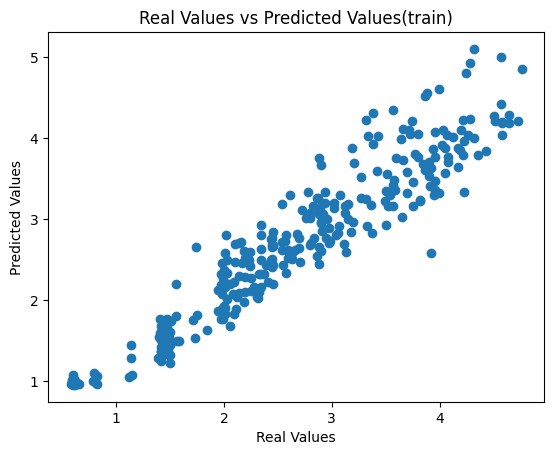

Train loss 0.11287333725485951
train acc 0.56875
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/im2_5

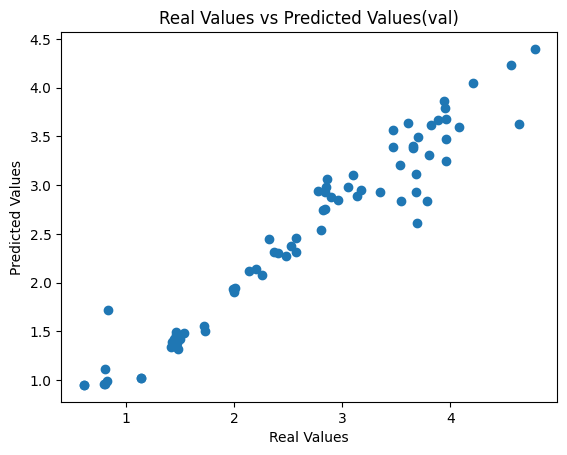

Val loss 0.1061299916356802
val acc 0.725
Epoch 11/60
----------
/content/drive/MyDrive/olive/segmented/md2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_1.jpg
/content/drive/MyDrive/olive/segmented/im14.jpg
/content/drive/MyDrive/olive/segmented/O_125721_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515.jpg
/content/drive/MyDrive/olive/segmented/md4_5_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_6.jpg
/content/drive/MyDrive/olive/segmented/im12_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_flip_6.jpg
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/im5_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_6.jpg
/

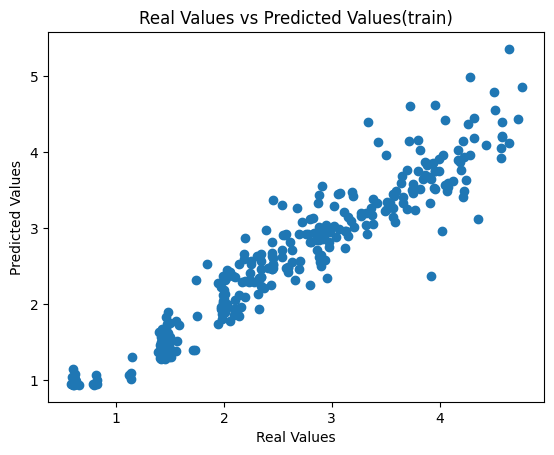

Train loss 0.10371990939602256
train acc 0.60625
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/

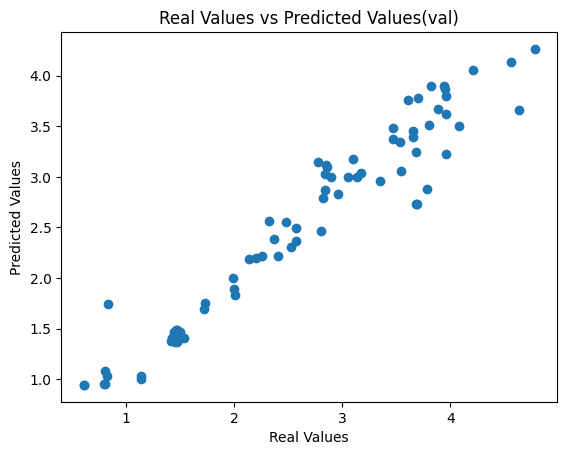

Val loss 0.10014150962233544
val acc 0.7375
Epoch 12/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_4.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_1.jpg
/content/drive/MyDrive/olive/segmented/md4_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_2.jpg
/content/drive/MyDrive/olive/segmented/im13_5.jpg
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/O_130123_3.jpg
/content/drive/MyDrive/olive/segmented/im3_4.jpg
/content/drive/MyDrive/olive/segmented/im5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_1.jpg
/c

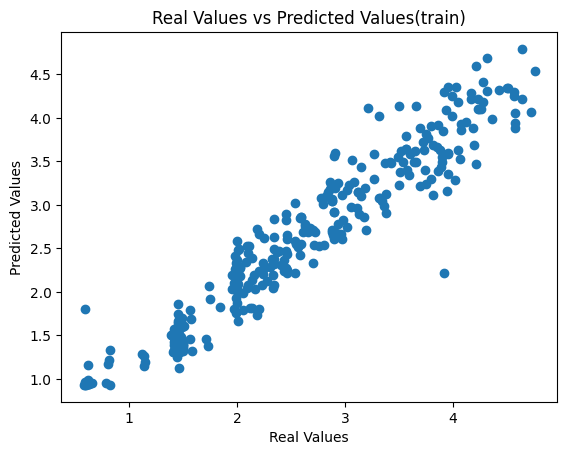

Train loss 0.09279361942317337
train acc 0.6
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDr

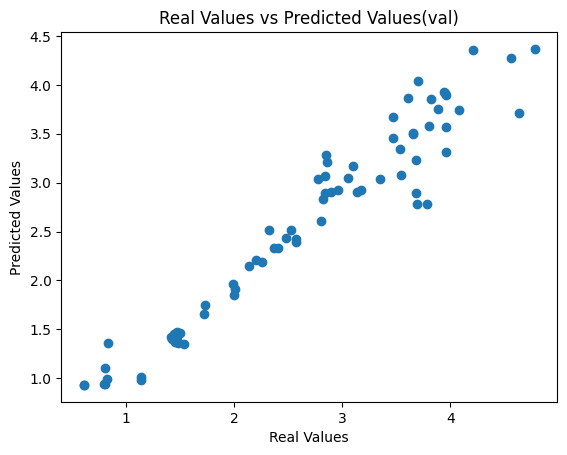

Val loss 0.08270596573129296
val acc 0.7375
Epoch 13/60
----------
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_7.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_1.jpg
/content/drive/MyDrive/olive/segmented/md2_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_6.jpg
/content/drive/MyDrive/olive/segmented/im1_4.jpg
/content/drive/MyDrive/olive/segmented

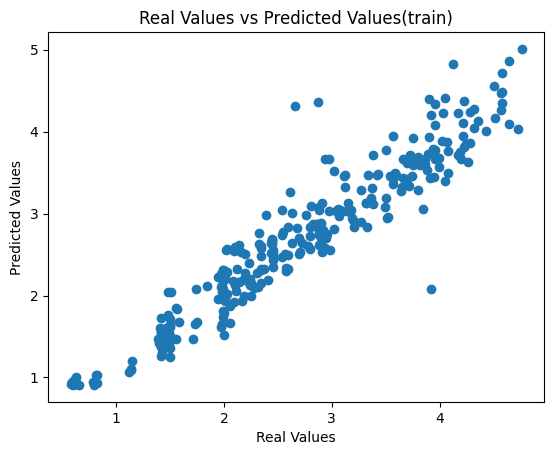

Train loss 0.09630251929629594
train acc 0.646875
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md7

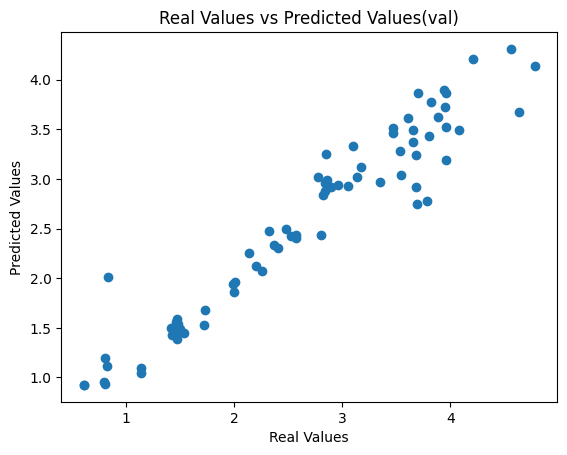

Val loss 0.10816184571012855
val acc 0.7375
Epoch 14/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_3.jpg
/content/drive/MyDrive/olive/segmented/md2_4.jpg
/content/drive/MyDrive/olive/segmented/im4_2.jpg
/content/drive/MyDrive/olive/segmented/md2_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/im1_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_5.jpg
/content/drive/MyDrive/olive/segmented/md7.jpg
/content/drive/MyDrive/olive/segmented/md1_4_8.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447.jpg
/content/drive/My

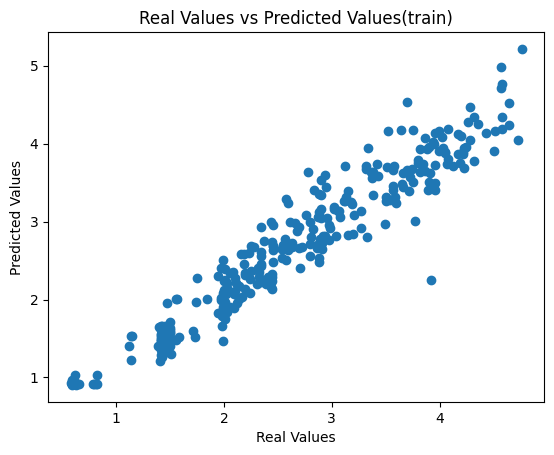

Train loss 0.08419461820740252
train acc 0.653125
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/dr

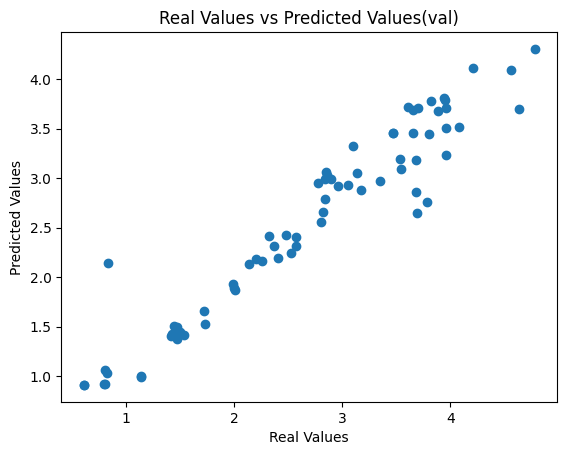

Val loss 0.1131665339693427
val acc 0.725
Epoch 15/60
----------
/content/drive/MyDrive/olive/segmented/md1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_flip_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_7.jpg
/content/drive/MyDrive/olive/segmented/O_131625_4.jpg
/content/drive/MyDrive/olive/segmented/im1_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_1.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_5.jpg
/content/drive/MyDrive/olive/segmented/im13_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_1.jpg
/content/drive/MyDrive/olive/segmented/O_130123_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_2.jpg
/co

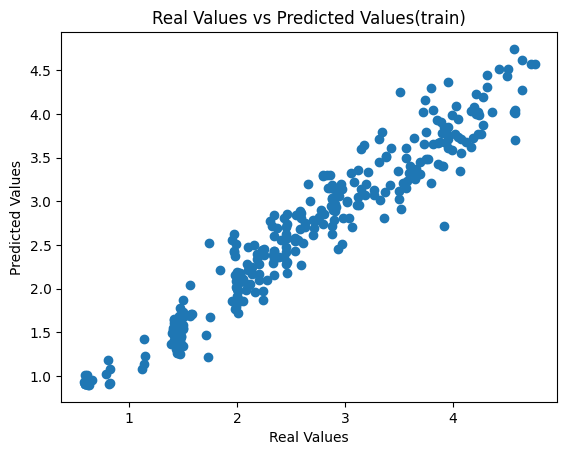

Train loss 0.07800403559813276
train acc 0.640625
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content

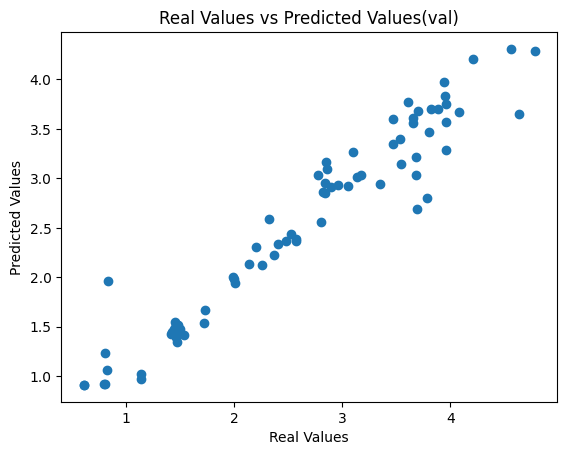

Val loss 0.09656616058200598
val acc 0.75
Epoch 16/60
----------
/content/drive/MyDrive/olive/segmented/md3_3.jpg
/content/drive/MyDrive/olive/segmented/md7_5.jpg
/content/drive/MyDrive/olive/segmented/im12_2_flip_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_4.jpg
/content/drive/MyDrive/olive/segmented/im1_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_122127_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_3.jpg
/content/drive/MyDrive/olive/segmented/im9_3.jpg
/content/drive/MyDrive/olive/segmented/im4_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_1259

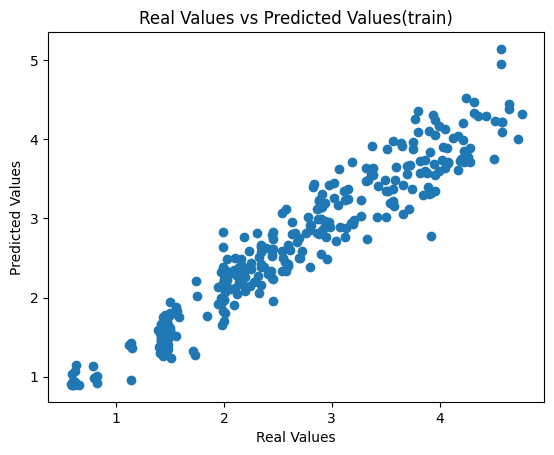

Train loss 0.08622486409731209
train acc 0.584375
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/

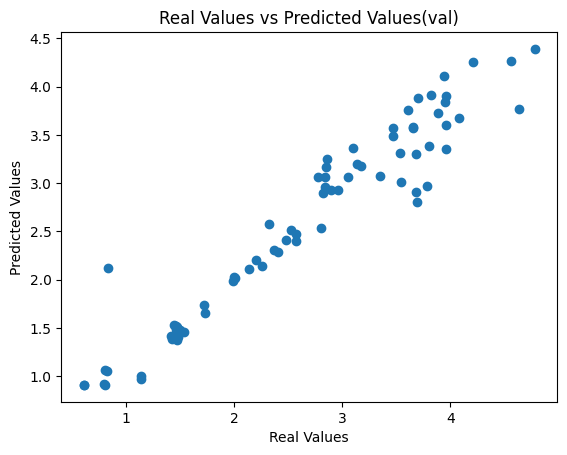

Val loss 0.09176923921331763
val acc 0.7125
Epoch 17/60
----------
/content/drive/MyDrive/olive/segmented/O_125721_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im9.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/md8_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/md2_3.jpg
/content/drive/MyDrive/olive/segmented/O_130123_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_2.jpg
/content/drive/MyDrive/olive/segmented/O_124141.jpg
/content/drive/MyDrive/olive/segmented/IMG_2

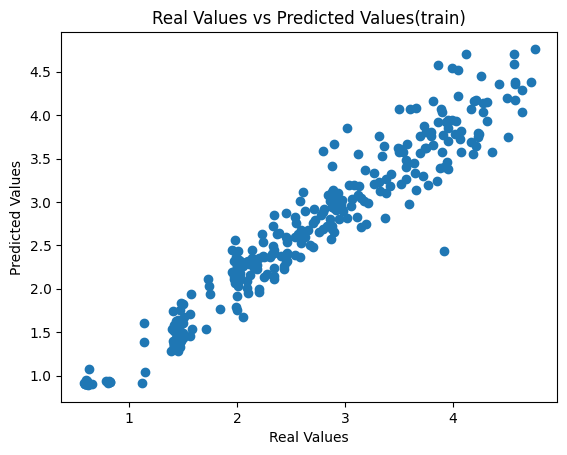

Train loss 0.07828024963382632
train acc 0.69375
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDri

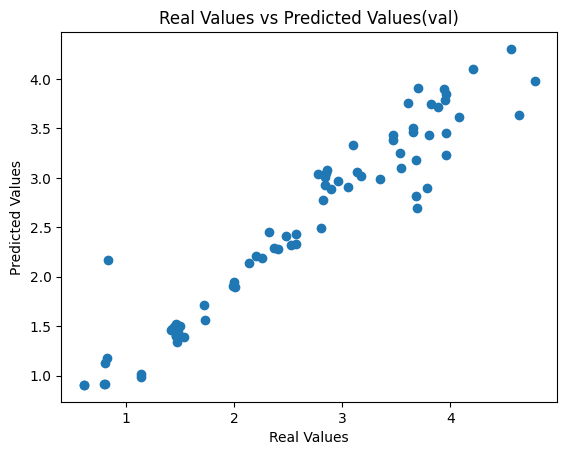

Val loss 0.11444004243239761
val acc 0.7375
Epoch 18/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_3.jpg
/content/drive/MyDrive/olive/segmented/im5_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056.jpg
/content/drive/MyDrive/olive/segmented/im9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im1_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_1.jpg
/content/drive/MyDrive/olive/segme

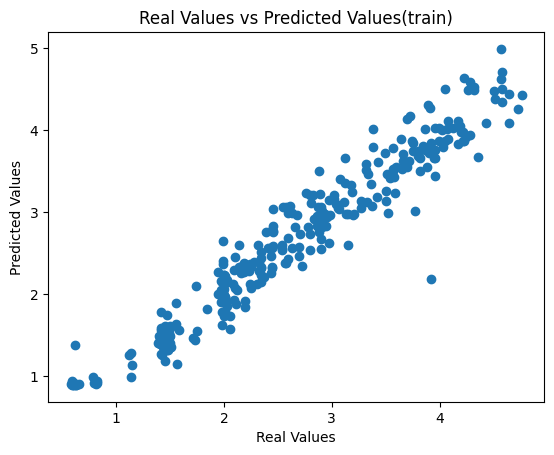

Train loss 0.06759483839850873
train acc 0.70625
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/

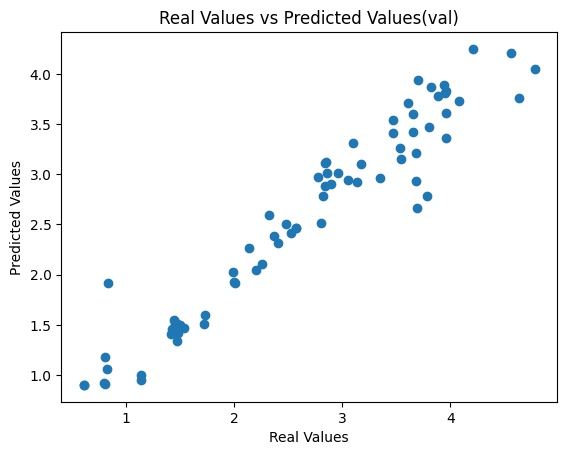

Val loss 0.0980458783917129
val acc 0.725
Epoch 19/60
----------
/content/drive/MyDrive/olive/segmented/im3_2.jpg
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547.jpg
/content/drive/MyDrive/olive/segmented/md1_4_10.jpg
/content/drive/MyDrive/olive/segmented/im12_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920.jpg
/content/drive/MyDrive/olive/segmented/md2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_2.jpg
/content/drive/MyDrive/olive/segmented/O_131625_1.

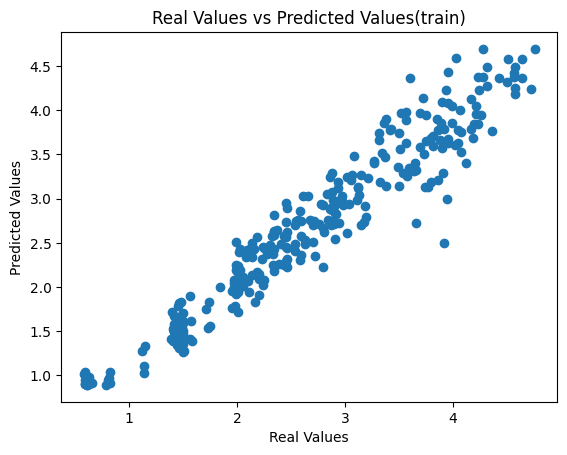

Train loss 0.07542159534059464
train acc 0.6625
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/

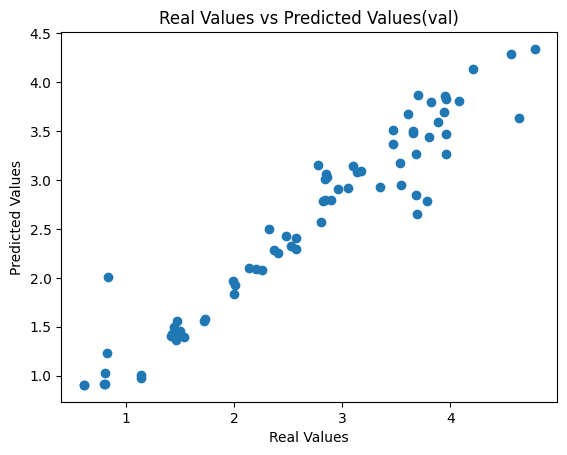

Val loss 0.10786569323390723
val acc 0.7375
Epoch 20/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_081229.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_5.jpg
/content/drive/MyDrive/olive/segmented/im10_1.jpg
/content/drive/MyDrive/olive/segmented/md2_8.jpg
/content/drive/MyDrive/olive/segmented/md1.jpg
/content/drive/MyDrive/olive/segmented/md1_4_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_6.jpg
/content/drive/MyDrive/olive/segmented/md4

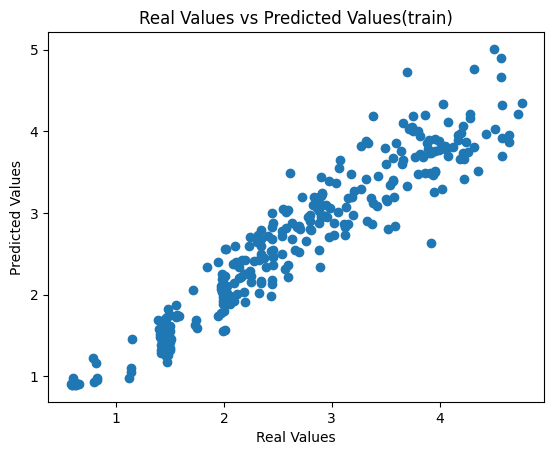

Train loss 0.0992110175313428
train acc 0.55625
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_0831

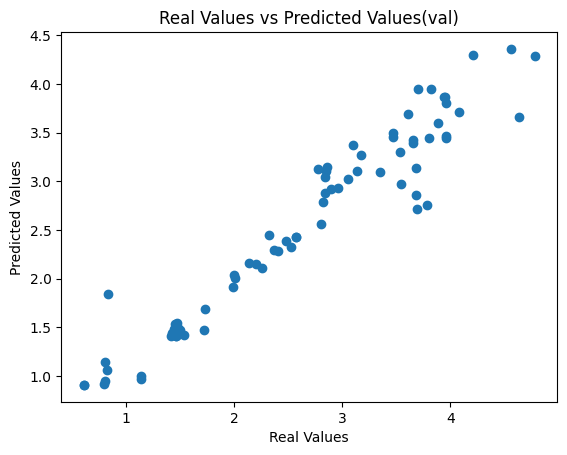

Val loss 0.09925502724945545
val acc 0.7
Epoch 21/60
----------
/content/drive/MyDrive/olive/segmented/im12_4.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/im12_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_3.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_3.jpg
/content/drive/MyDrive/olive/segmented/im7_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_8.jpg
/content/drive/MyDrive/olive/segmented/md7_2_6.jpg
/content/drive/MyDrive/olive/segmented/im6_5.jpg
/content/drive/MyDrive/olive/segmented/O_130123_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_8.jpg
/content/drive

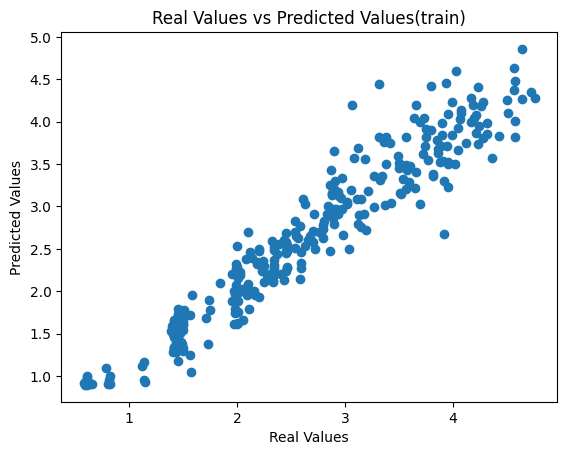

Train loss 0.08453685198910535
train acc 0.621875
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_08310

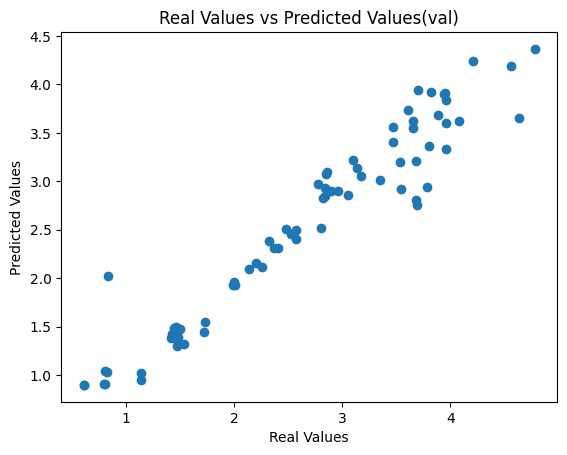

Val loss 0.09879699908196926
val acc 0.7625
Epoch 22/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_1.jpg
/content/drive/MyDrive/olive/segmented/md3_1_7.jpg
/content/drive/MyDrive/olive/segmented/im8_2.jpg
/content/drive/MyDrive/olive/segmented/md1_4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/md4_4_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_8.jpg
/content/drive/MyDrive/olive/segmented/im1_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_081229.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_4.jpg
/content/drive/MyDrive/olive/segment

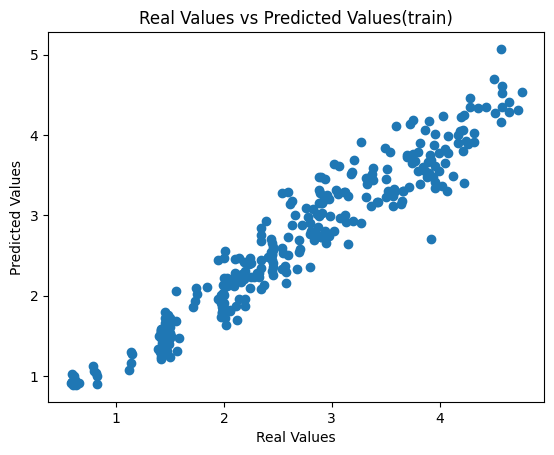

Train loss 0.07909787151729689
train acc 0.628125
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG

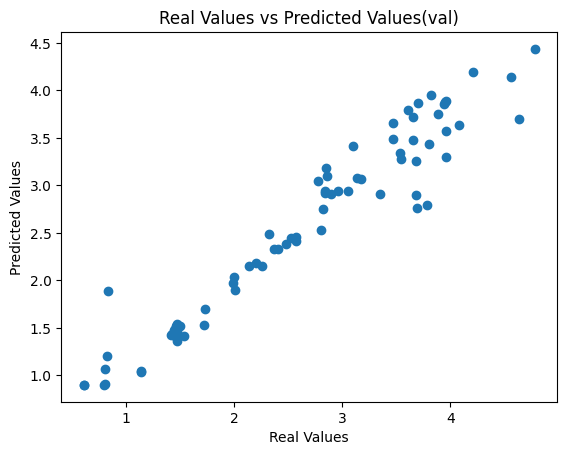

Val loss 0.092380285076797
val acc 0.725
Epoch 23/60
----------
/content/drive/MyDrive/olive/segmented/im12_2_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_2.jpg
/content/drive/MyDrive/olive/segmented/im1_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_4.jpg
/content/drive/MyDrive/olive/segmented/md2_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_9.jpg
/content/drive/MyDrive/olive/segmented/md2_2_8.jpg
/content/drive/MyDrive/olive/segmented/im11_1.jpg
/content/drive/MyDrive/olive/segmented/im14.jpg
/content/drive/MyDrive/olive/segmented/md2_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942_5.jpg
/content/drive/MyDrive/olive/segmented/md4_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405.jpg
/content/drive/MyDri

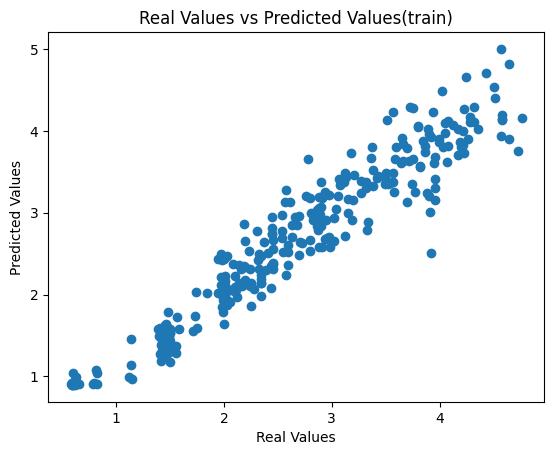

Train loss 0.08504285621456802
train acc 0.628125
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im12

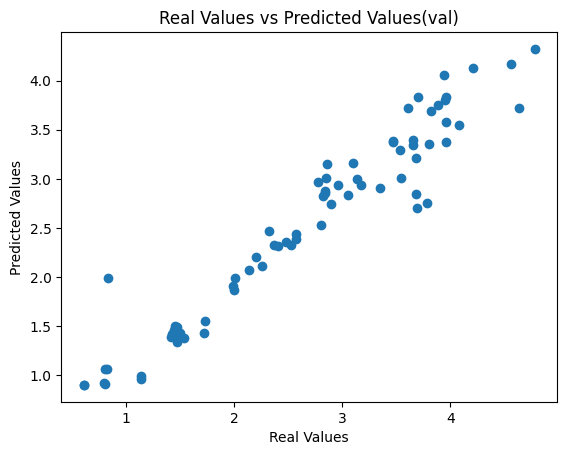

Val loss 0.10491871330887079
val acc 0.725
Epoch 24/60
----------
/content/drive/MyDrive/olive/segmented/md3_4.jpg
/content/drive/MyDrive/olive/segmented/md1_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_5.jpg
/content/drive/MyDrive/olive/segmented/md1_4_8.jpg
/content/drive/MyDrive/olive/segmented/im14_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_1.jpg
/content/drive/MyDrive/olive/segmented/O_131625_4.jpg
/content/drive/MyDrive/olive/segmented/md3_3_6.jpg
/content/drive/MyDrive/olive/segmented/im5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/im12_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/i

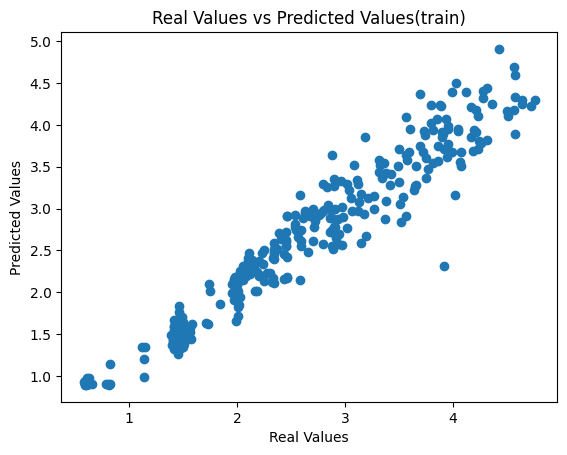

Train loss 0.07488690759055316
train acc 0.659375
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segm

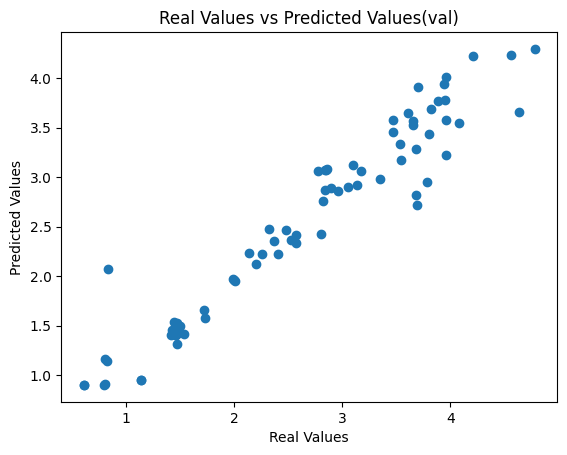

Val loss 0.10189784006215633
val acc 0.75
Epoch 25/60
----------
/content/drive/MyDrive/olive/segmented/im12_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_7.jpg
/content/drive/MyDrive/olive/segmented/md2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_flip_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_5.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_5.jpg
/content/drive/MyDrive/olive/segmented/md7_5.jpg
/content/drive/MyDrive/olive/segmen

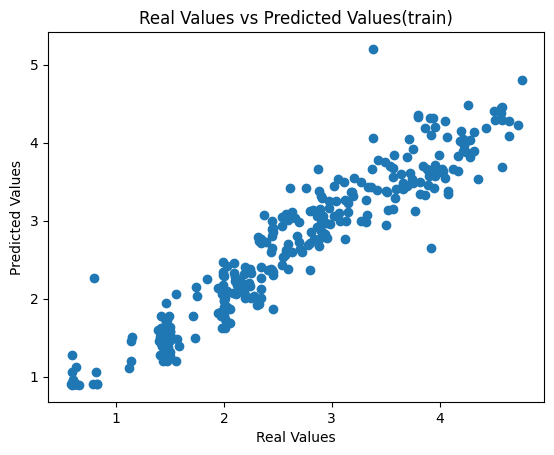

Train loss 0.10668273759074509
train acc 0.578125
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/dr

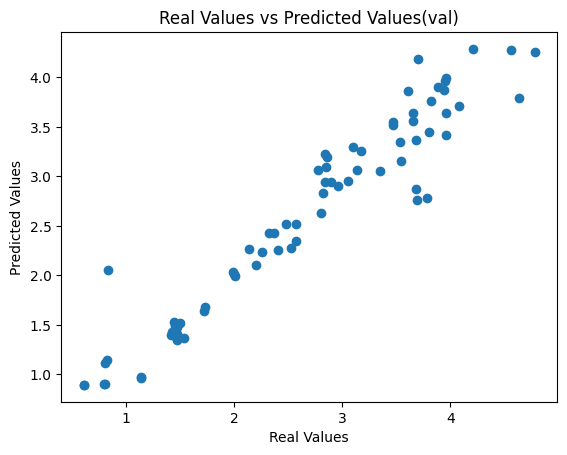

Val loss 0.09558204310014844
val acc 0.7
Epoch 26/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_5.jpg
/content/drive/MyDrive/olive/segmented/md1.jpg
/content/drive/MyDrive/olive/segmented/md2_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/MyDrive/olive/segmented/O_130123_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im2_1.jpg
/content/drive/MyDrive/olive/segmented/md7_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_2.jpg
/content/drive/MyDrive/olive/segmented/O_124141_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_10.jpg
/content/drive/MyDrive/olive/segm

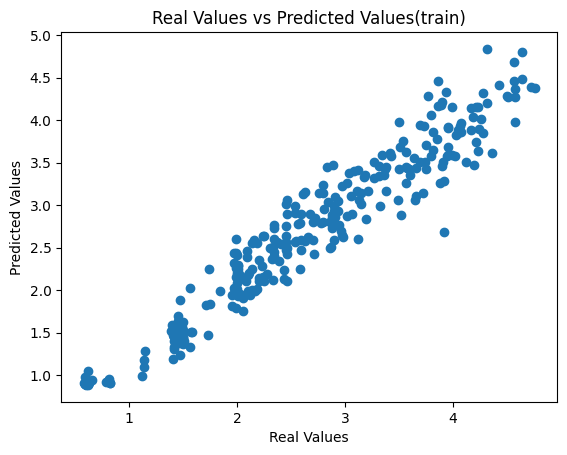

Train loss 0.07373449692968279
train acc 0.65625
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/d

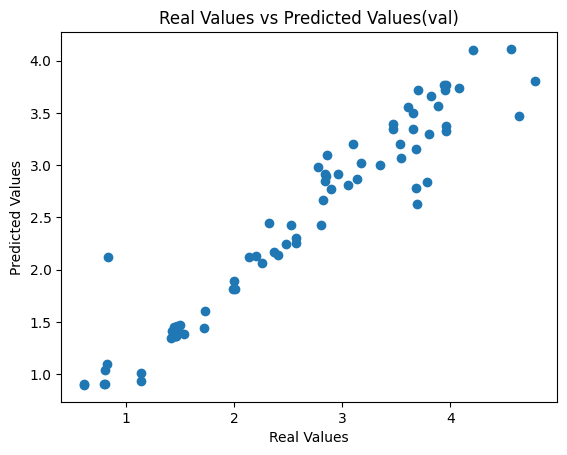

Val loss 0.13320931158959864
val acc 0.675
Epoch 27/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_9.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive/olive/segmented/im7_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501.jpg
/content/drive/MyDrive/olive/segmented/im11_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_4.jpg
/content/drive/MyDrive/ol

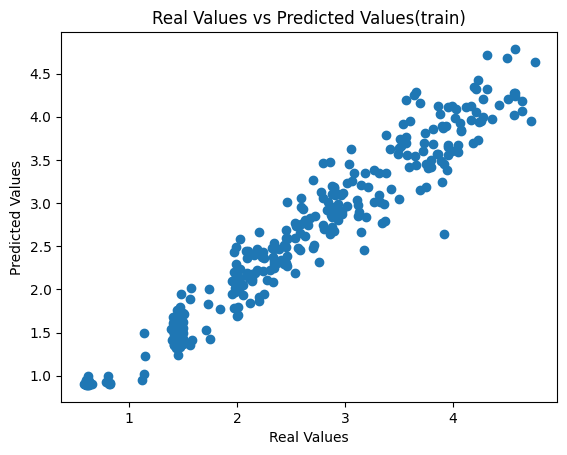

Train loss 0.07382566689047962
train acc 0.646875
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/conten

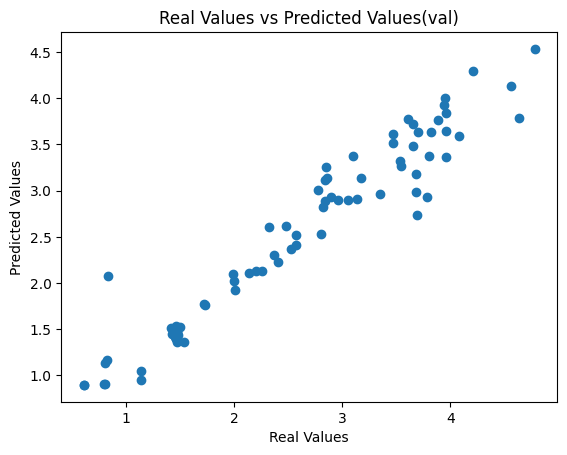

Val loss 0.09412810374051332
val acc 0.7125
Epoch 28/60
----------
/content/drive/MyDrive/olive/segmented/im12_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_9.jpg
/content/drive/MyDrive/olive/segmented/im1_3.jpg
/content/drive/MyDrive/olive/segmented/im14_5_rotation_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_3.jpg
/content/drive/MyDrive/olive/segmented/md1_5.jpg
/content/drive/MyDrive/olive/segmented/md8_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_7.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_5.jpg
/content/drive/MyDrive/olive/segmented/im7_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_7.jpg
/content/drive/MyDrive/olive/segmented/md8.jpg
/content/

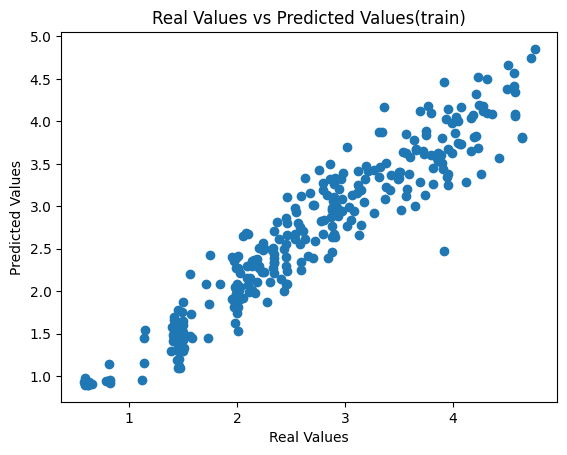

Train loss 0.09666957834269851
train acc 0.584375
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/dr

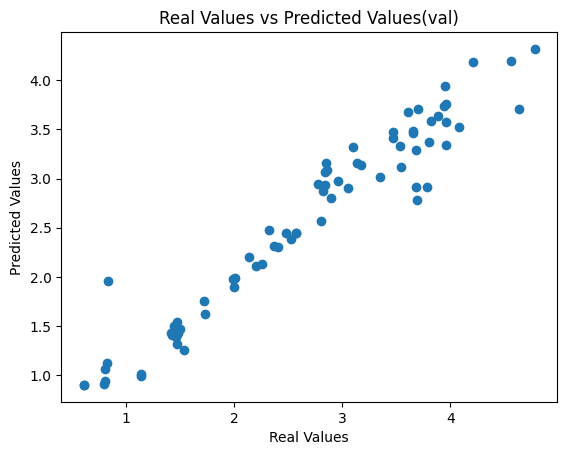

Val loss 0.09299751603975892
val acc 0.7375
Epoch 29/60
----------
/content/drive/MyDrive/olive/segmented/im1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659.jpg
/content/drive/MyDrive/olive/segmented/O_124141_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_9.jpg
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_4.jpg
/content/drive/MyDrive/olive/segmented/md1_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_

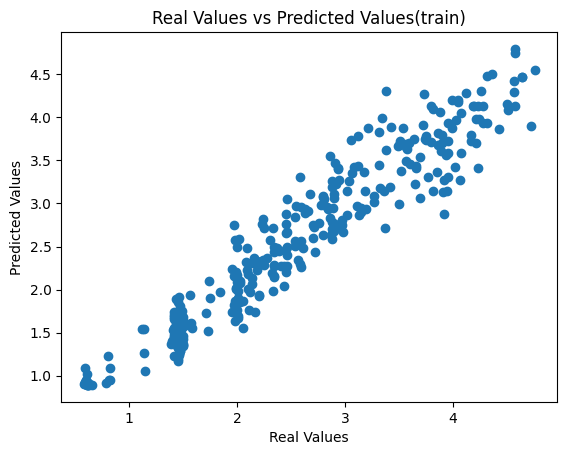

Train loss 0.09542760967742651
train acc 0.603125
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmen

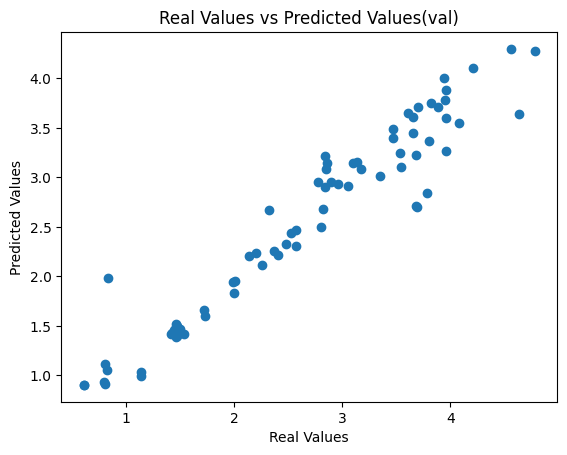

Val loss 0.10598118305206299
val acc 0.7125
Epoch 30/60
----------
/content/drive/MyDrive/olive/segmented/md2_2.jpg
/content/drive/MyDrive/olive/segmented/md1_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_5.jpg
/content/drive/MyDrive/olive/seg

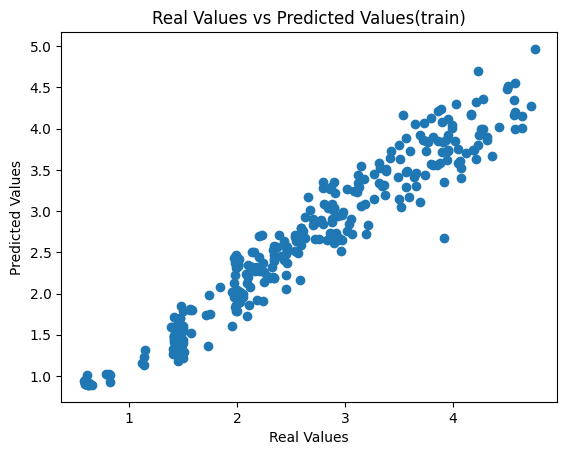

Train loss 0.07116878784727305
train acc 0.640625
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmente

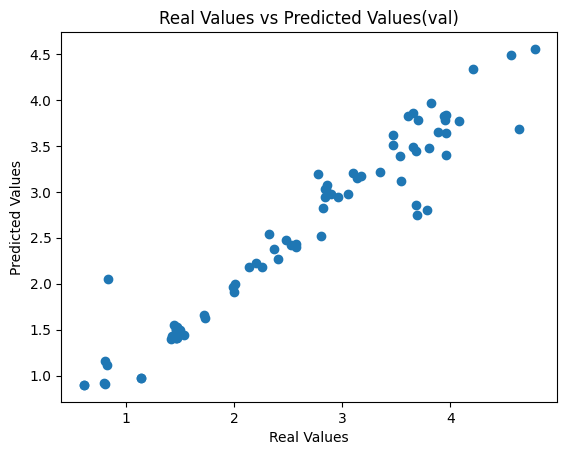

Val loss 0.08960105860605835
val acc 0.8
Epoch 31/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_10.jpg
/content/drive/MyDrive/olive/segmented/md1_4_10.jpg
/content/drive/MyDrive/olive/segmented/md3_3_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_4.jpg
/content/drive/MyDrive/olive/segmented/md7_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920.jpg
/content/drive/MyDrive/olive/segmented/im8_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_1.jpg
/content/drive/MyDrive/olive/segmen

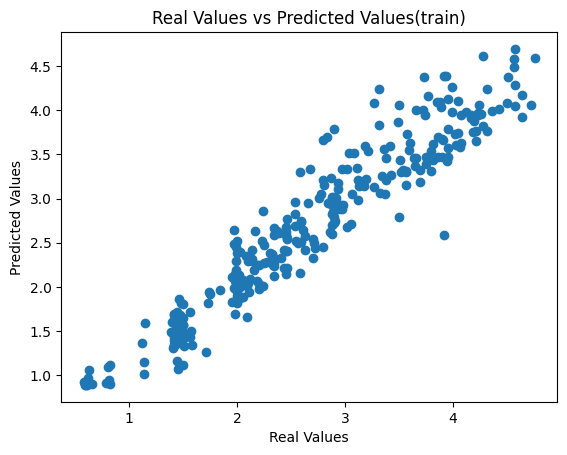

Train loss 0.08958582323975861
train acc 0.59375
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/M

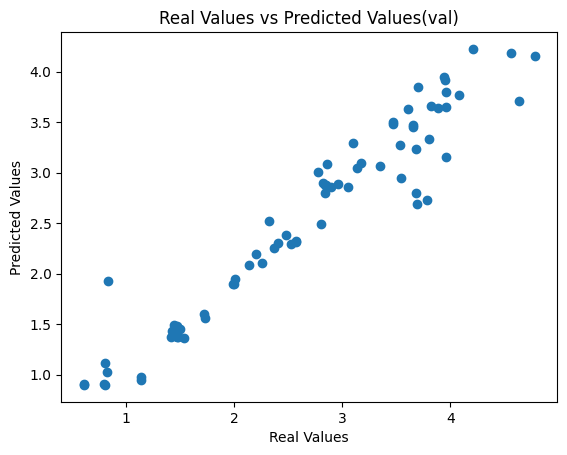

Val loss 0.10699370820075274
val acc 0.7375
Epoch 32/60
----------
/content/drive/MyDrive/olive/segmented/md8_4.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im1.jpg
/content/drive/MyDrive/olive/segmented/md7_2.jpg
/content/drive/MyDrive/olive/segmented/im8_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_8.jpg
/content/drive/MyDrive/olive/segmented/im13_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_3.jpg
/content/drive/MyDrive/olive/segmented/im3_2.jpg
/content/drive/MyDrive/olive/segmented/im5_4.jpg
/content/drive/MyDrive/olive/segmented/md2_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_122127_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603

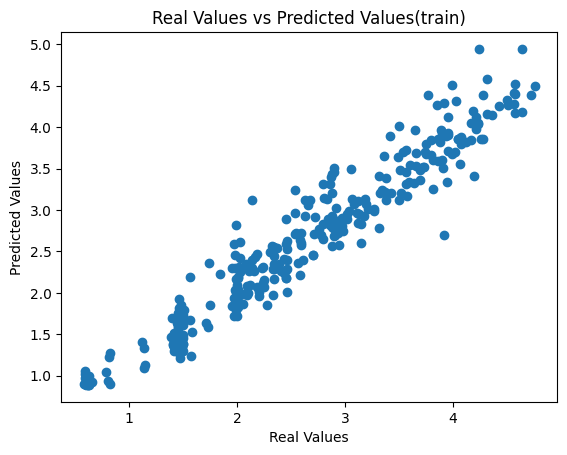

Train loss 0.07831545521039515
train acc 0.6375
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/My

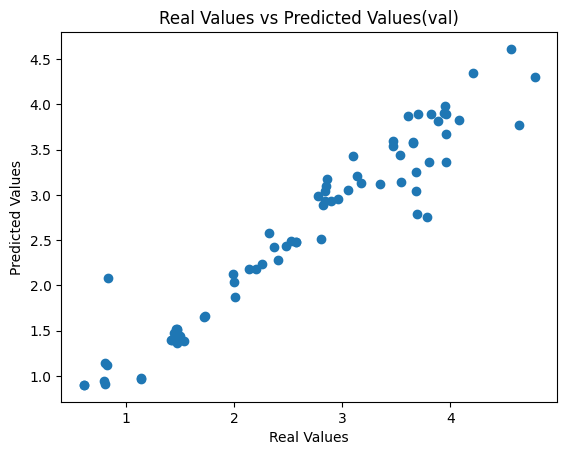

Val loss 0.09011124633252621
val acc 0.7375
Epoch 33/60
----------
/content/drive/MyDrive/olive/segmented/im12_2_flip_9.jpg
/content/drive/MyDrive/olive/segmented/O_124141_5.jpg
/content/drive/MyDrive/olive/segmented/md3_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_1.jpg
/content/drive/MyDrive/olive/segmented/im5_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_2.jpg
/content/drive/MyDrive/olive/segmented/im9_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8.jpg
/content/drive/MyDrive/olive/segmented/im6_5.jpg
/content/drive/MyDrive/olive/segmented/O_124141_3.jpg
/content/drive/MyDrive/olive/segmented/md2_1_9.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/md3_1_7.jpg
/content/drive/MyDrive/olive/segmented/im4_1.jpg
/content/drive/MyDrive/olive/segmented/md4_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428.jpg
/content/d

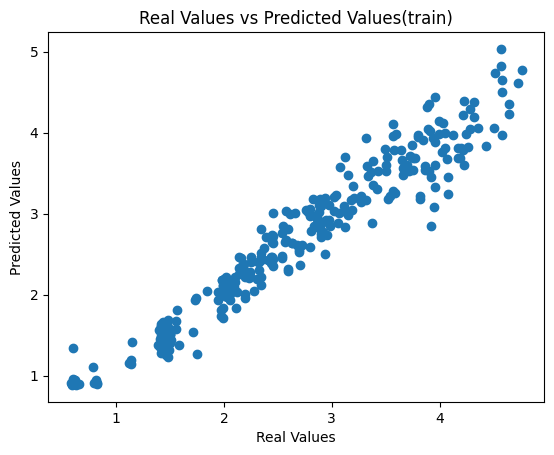

Train loss 0.06323878723196685
train acc 0.71875
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented

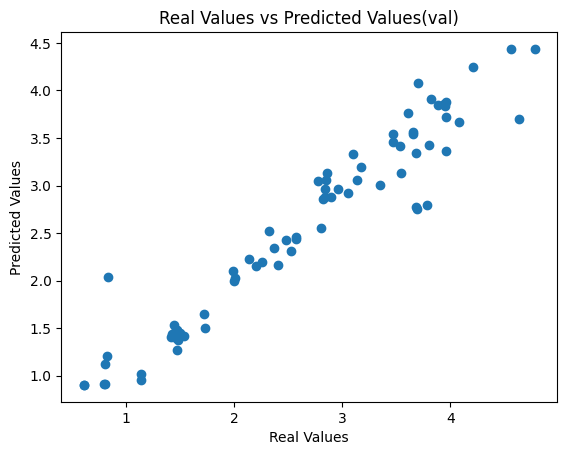

Val loss 0.09614349212497472
val acc 0.7625
Epoch 34/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_4.jpg
/content/drive/MyDrive/olive/segmented/im7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_10.jpg
/content/drive/MyDrive/olive/segmented/im8.jpg
/content/drive/MyDrive/olive/segmented/md4_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_10.jpg
/content/drive/

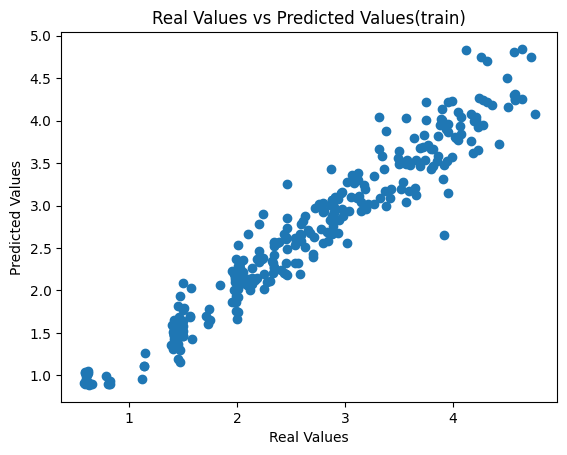

Train loss 0.06839594291523099
train acc 0.7
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_

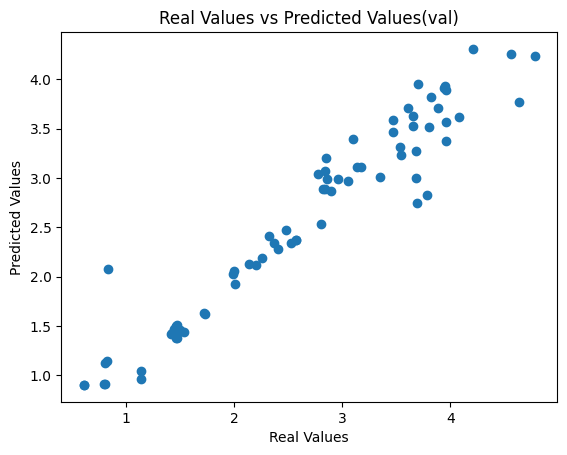

Val loss 0.09269468635320663
val acc 0.7125
Epoch 35/60
----------
/content/drive/MyDrive/olive/segmented/O_130123_1.jpg
/content/drive/MyDrive/olive/segmented/im11_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_8.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/im12_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md1_10.jpg
/content/drive/MyDrive/olive/segmented/im7_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659.jpg
/content/drive/MyDrive/olive/segmented/md7_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_4.jpg
/content/drive/MyDrive/olive/segmented/im4_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im14_2.jpg
/content/drive/MyDrive/olive/segmented/im2_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115

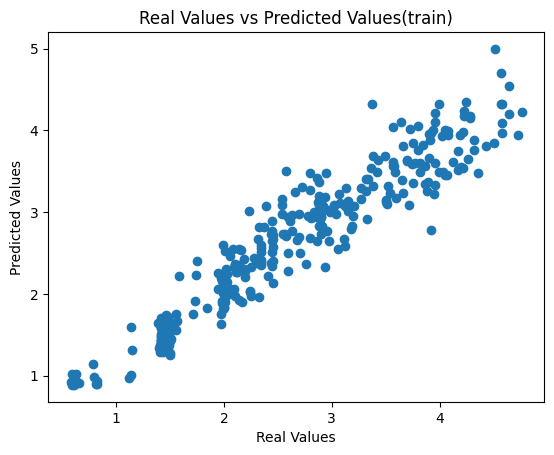

Train loss 0.0992834949400276
train acc 0.6125
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/

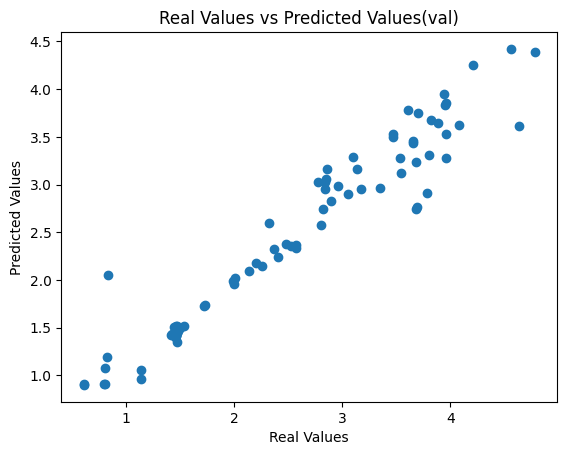

Val loss 0.10309430714696646
val acc 0.75
Epoch 36/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_7.jpg
/content/drive/MyDrive/olive/segmented/im8_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_translation_7.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_3.jpg
/content/drive/MyDrive/olive/segmented/md2.jpg
/content/drive/MyDrive/olive/segmented/O_124141.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520.jpg
/content/drive/MyDrive/olive/segmented/md4_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220

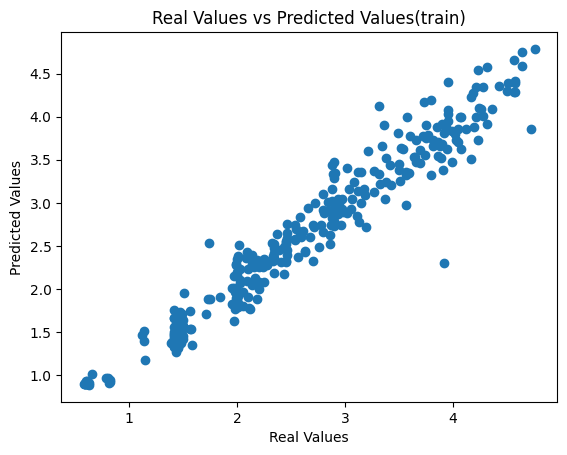

Train loss 0.06095377260935493
train acc 0.715625
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220

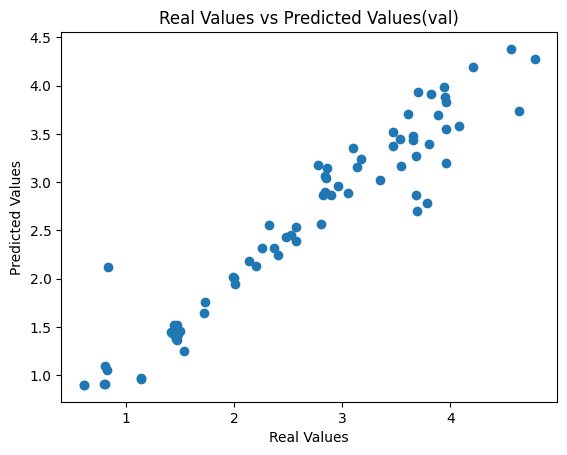

Val loss 0.10370435006916523
val acc 0.75
Epoch 37/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4.jpg
/content/drive/MyDrive/olive/segmented/O_124141_1.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/MyDrive/olive/segmented/O_124141_3.jpg
/content/drive/MyDrive/olive/segmented/im9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_4.jpg
/content/drive/MyDrive/olive/segmented/im6.jpg
/content/drive/MyDrive/olive/segmented/im10_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_122127_2.jpg
/content/drive/MyDrive/olive/segmented/im14_2.jpg
/content/drive/MyDrive/olive/segmented/im13_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_4.jpg
/content/drive/MyDrive/olive/segmented

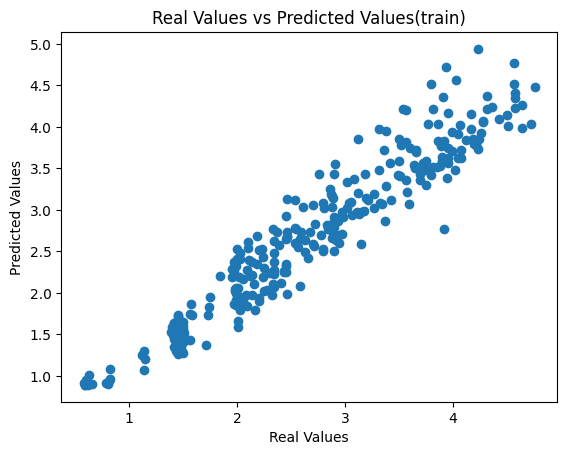

Train loss 0.0832595705287531
train acc 0.596875
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segme

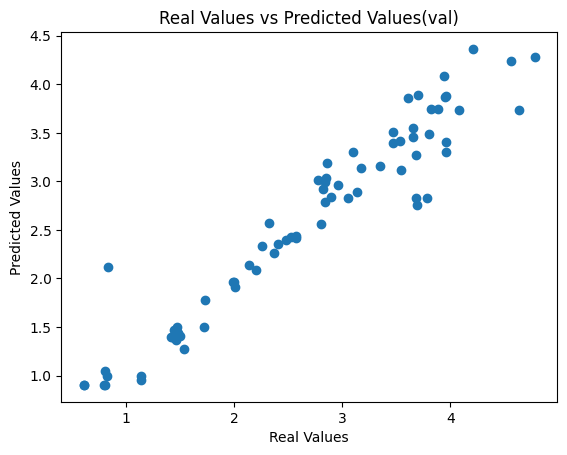

Val loss 0.10018417667597532
val acc 0.7625
Epoch 38/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_5.jpg
/content/drive/MyDrive/olive/segmented/im7.jpg
/content/drive/MyDrive/olive/segmented/O_125721_1.jpg
/content/drive/MyDrive/olive/segmented/im14.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059.jpg
/content/drive/MyDrive/olive/segmented/md1_4_6.jpg
/content/drive/MyDrive/olive/segmented/md1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_2.jpg
/content/drive/MyDrive/olive/segmented/I

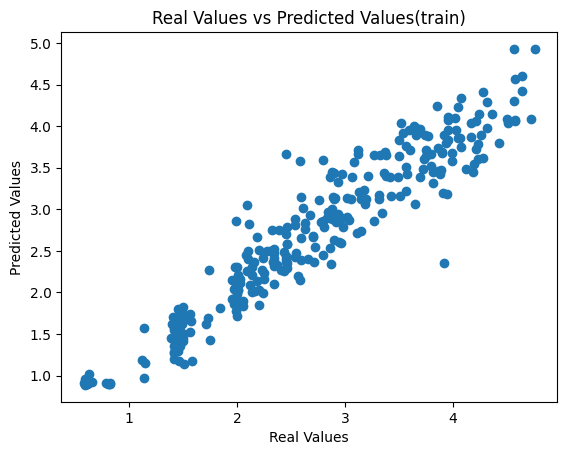

Train loss 0.09496291661635041
train acc 0.6125
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.

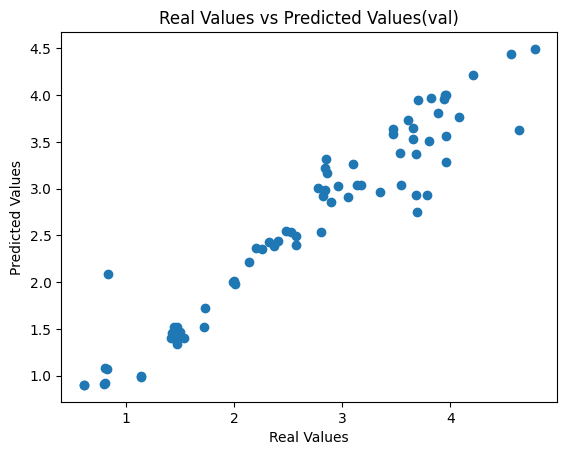

Val loss 0.09487045854330063
val acc 0.75
Epoch 39/60
----------
/content/drive/MyDrive/olive/segmented/im11_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_3.jpg
/content/drive/MyDrive/olive/segmented/im5.jpg
/content/drive/MyDrive/olive/segmented/md8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_5.jpg
/content/drive/MyDrive/olive/segmented/md8_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_1.jpg
/content/drive/MyDrive/olive/segmented/md3_3_6.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_3.jpg
/content/drive/MyDrive/olive/segmented/im3_2.jpg
/content/drive/MyDrive/olive/segmented/im13_3.jpg
/content/drive/My

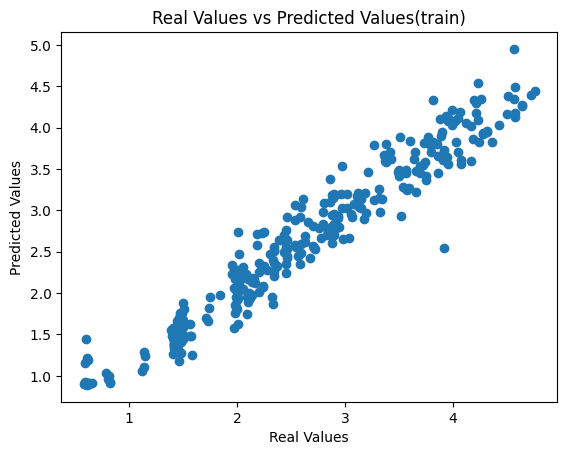

Train loss 0.06583170173689723
train acc 0.678125
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603

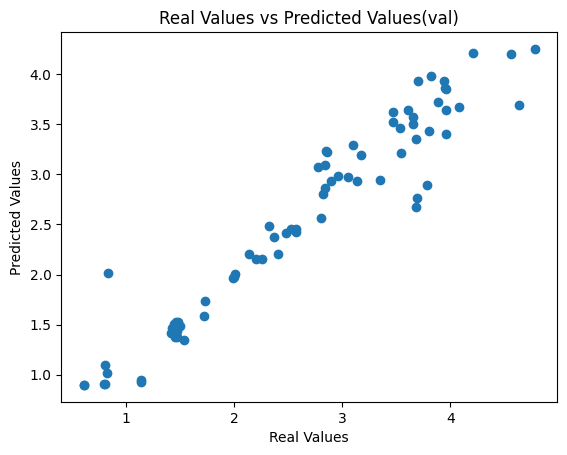

Val loss 0.09764881683513522
val acc 0.7375
Epoch 40/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_3.jpg
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/im6_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_122127_2.jpg
/content/drive/MyDrive/olive/segmented/O_130123_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_9.jpg
/content/drive/

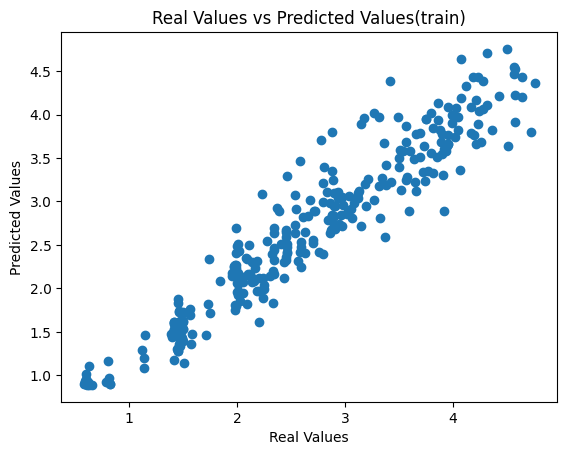

Train loss 0.09554863404482603
train acc 0.64375
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.

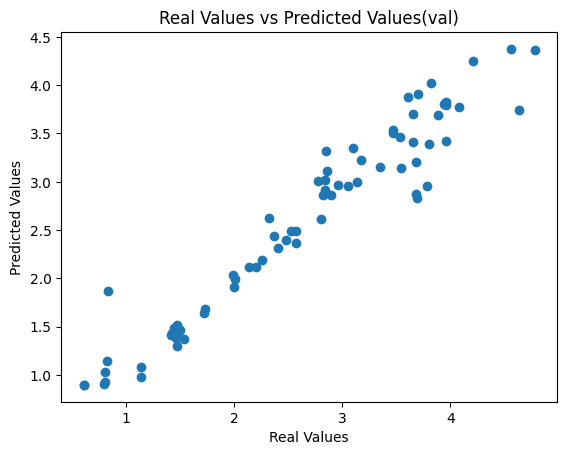

Val loss 0.08293672669678927
val acc 0.7875
Epoch 41/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_5.jpg
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im12_2_flip_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/O_124141_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748.jpg
/content/drive/MyDrive/olive/segmented/O_125721_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_5.jpg
/content/drive/MyDrive/olive/segmented/IMG

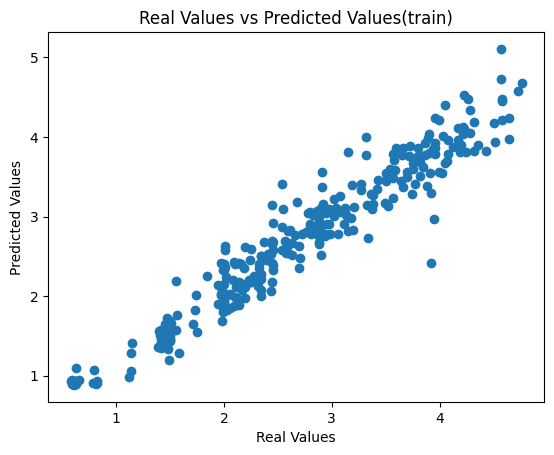

Train loss 0.07123689049622044
train acc 0.7
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/m

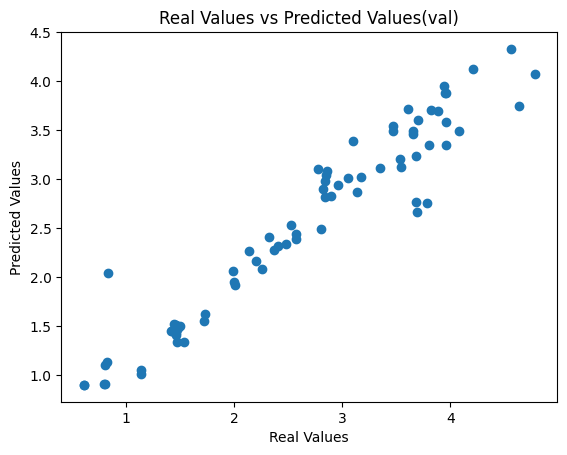

Val loss 0.10841834573075175
val acc 0.7375
Epoch 42/60
----------
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_2.jpg
/content/drive/MyDrive/olive/segmented/O_125721_3.jpg
/content/drive/MyDrive/olive/segmented/md3_3.jpg
/content/drive/MyDrive/olive/segmented/md1_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_3.jpg
/content/drive/MyDrive/olive/segmented/md2_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_translation_8.jpg
/content/drive/MyDrive/olive/segmented/im7_2.jpg
/content/drive/MyDrive/olive/segmented/md2_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_6.jpg
/co

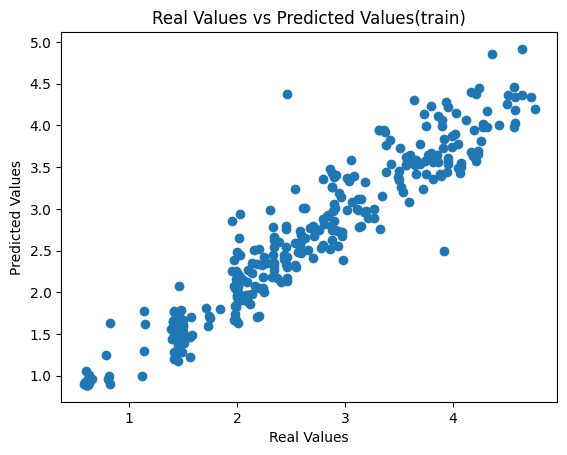

Train loss 0.10655893156072124
train acc 0.584375
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/o

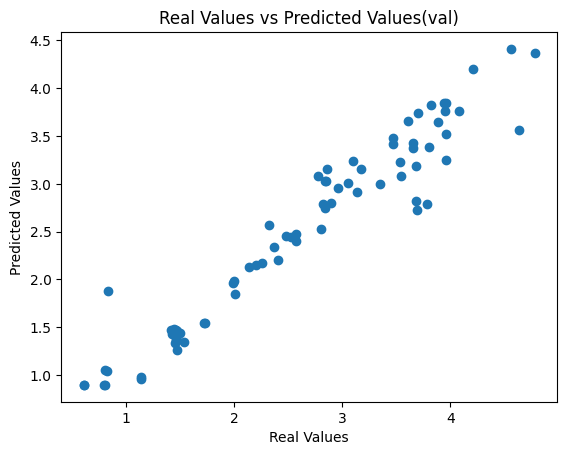

Val loss 0.10142064690589905
val acc 0.7375
Epoch 43/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921.jpg
/content/drive/MyDrive/olive/segmented/im9_3.jpg
/content/drive/MyDrive/olive/segmented/im13_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8.jpg
/content/drive/MyDrive/olive/segmented/md2_9.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_translation_7.jpg
/content/drive/MyDrive/olive/segmented/O_130123_1.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_3.jpg
/content/drive/MyDrive/olive/segmented/md1_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_5.jpg
/content/drive/MyDrive/olive/segmented/md2_1_9.jpg
/content/drive/MyDriv

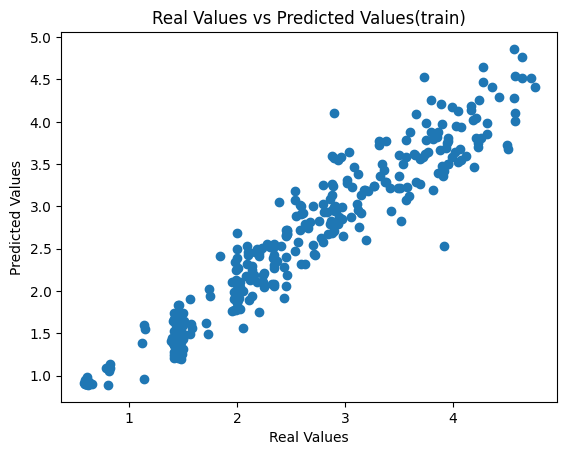

Train loss 0.09318222180008888
train acc 0.5875
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_2

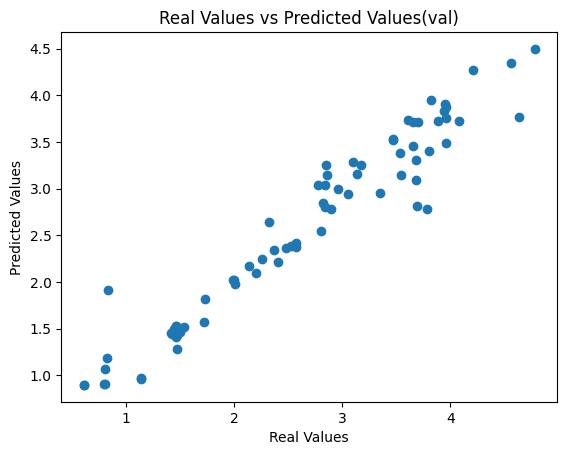

Val loss 0.08186916783452033
val acc 0.7375
Epoch 44/60
----------
/content/drive/MyDrive/olive/segmented/im1_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_10.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/md7_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_1.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/MyDrive/olive/segmented/im9.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_10.jpg
/content/drive/MyDrive/olive/segmented/O_130123_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_

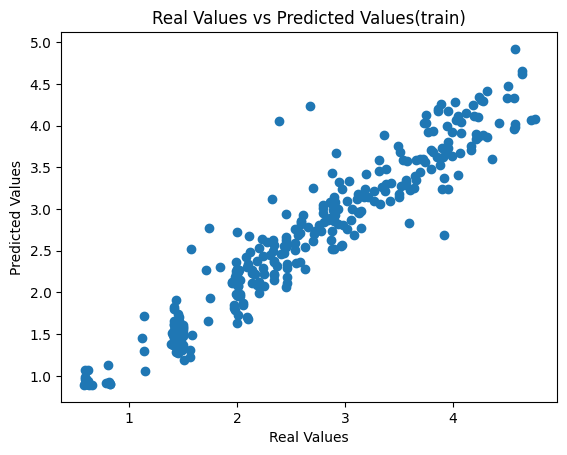

Train loss 0.09863223324064166
train acc 0.640625
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translat

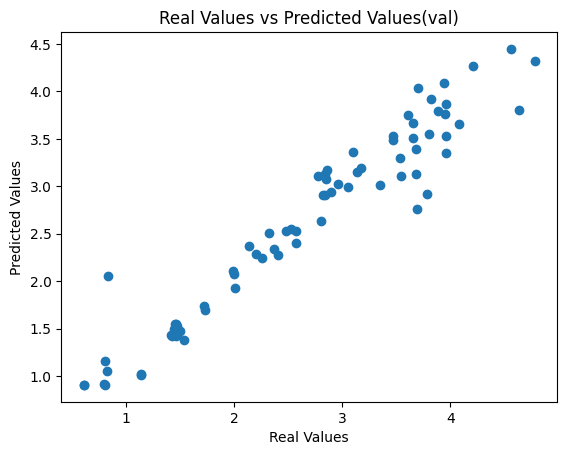

Val loss 0.0863212606869638
val acc 0.7375
Epoch 45/60
----------
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_3.jpg
/content/drive/MyDrive/olive/segmented/im11_4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/im10_1.jpg
/content/drive/MyDrive/olive/segmented/im1_2.jpg
/content/drive/MyDrive/olive/segmented/md2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_9.jpg
/conten

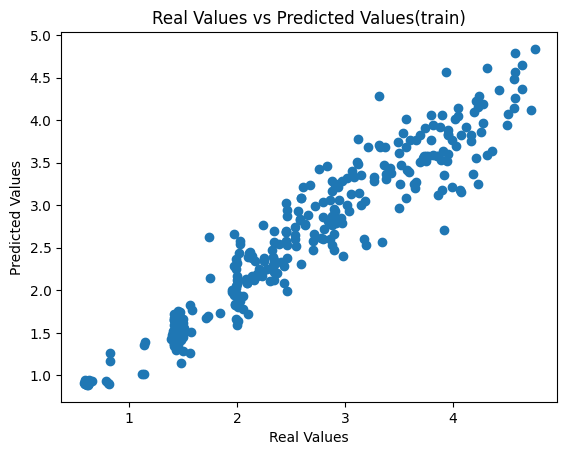

Train loss 0.09728638844098896
train acc 0.590625
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/se

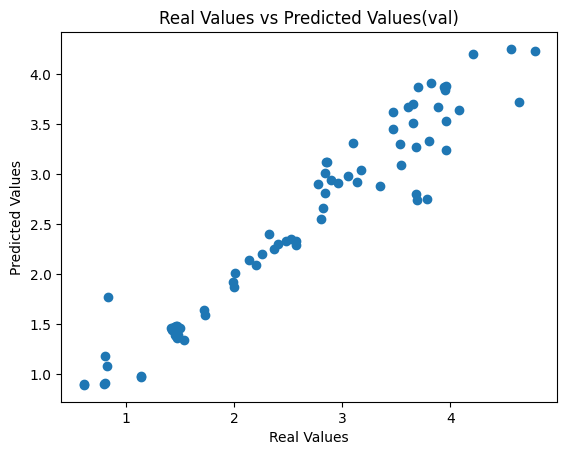

Val loss 0.09874597061425447
val acc 0.7375
Epoch 46/60
----------
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_5.jpg
/content/drive/MyDrive/olive/segmented/O_125721_1.jpg
/content/drive/MyDrive/olive/segmented/im9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_081229.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003_5.jpg
/content/drive/MyDrive/olive/segmented/md2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_4.jpg
/content/drive/MyDrive/olive/segmented/O_130123_3.jpg
/content/drive/MyDrive/olive/segmented/md4_1.jpg
/content/drive/MyDrive/olive/segmente

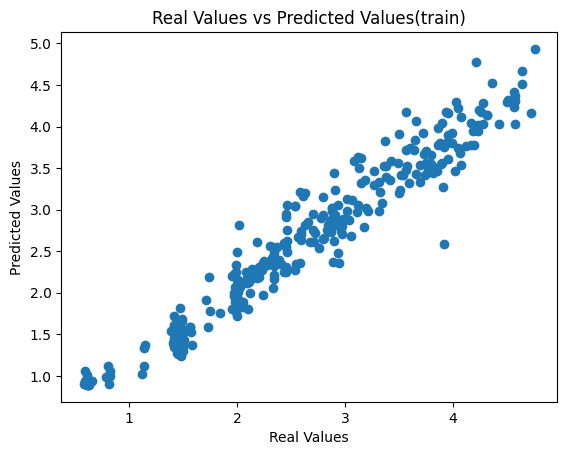

Train loss 0.06405230318196117
train acc 0.709375
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/c

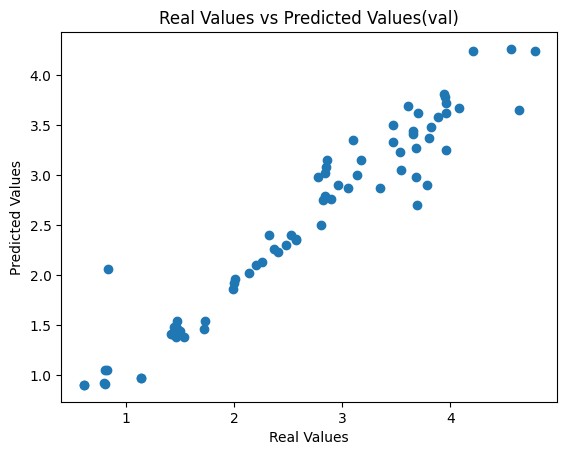

Val loss 0.10662356540560722
val acc 0.725
Epoch 47/60
----------
/content/drive/MyDrive/olive/segmented/im7_3.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_1_7.jpg
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_1.jpg
/content/drive/MyDrive/olive/segmented/O_125721_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_2.jpg
/content/drive/MyDrive/olive/segmented/md3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_1.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_4.jpg
/content/drive/MyDrive/olive/segmen

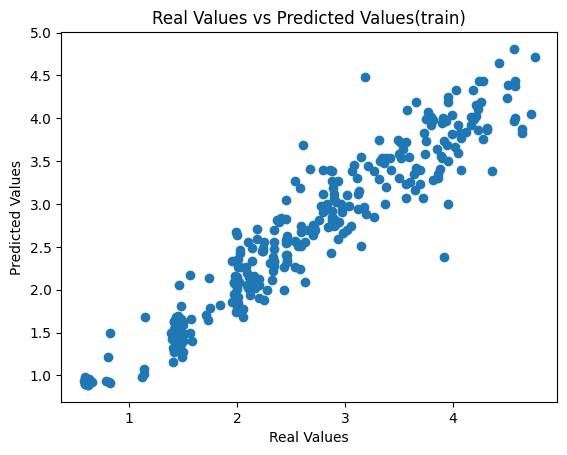

Train loss 0.10066481198882685
train acc 0.61875
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_

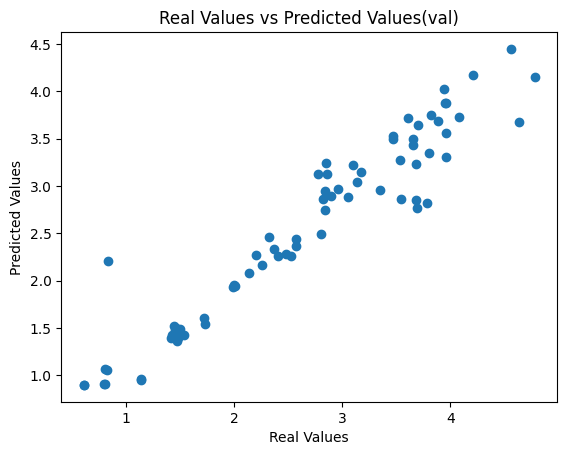

Val loss 0.1107421218417585
val acc 0.725
Epoch 48/60
----------
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_7.jpg
/content/drive/MyDrive/olive/segmented/md7_2.jpg
/content/drive/MyDrive/olive/segmented/md4_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im14_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_flip_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_12351

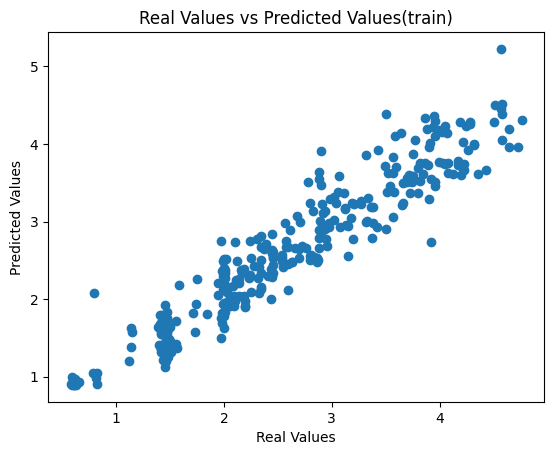

Train loss 0.10255224240245298
train acc 0.5625
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_0941

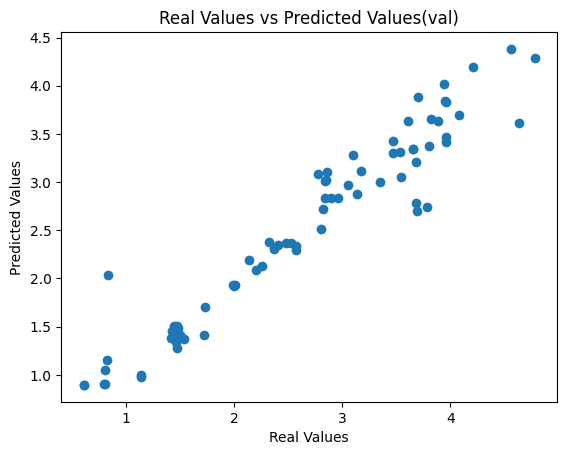

Val loss 0.11020776852965355
val acc 0.7
Epoch 49/60
----------
/content/drive/MyDrive/olive/segmented/md1_4_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_5.jpg
/content/drive/MyDrive/olive/segmented/im12_2_flip_6.jpg
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_3.jpg
/content/drive/MyDrive/olive/segmented/md7_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_2.jpg
/content/drive/MyDrive/olive/segmented/md1_4_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_3.jpg
/content/drive/MyDrive/oliv

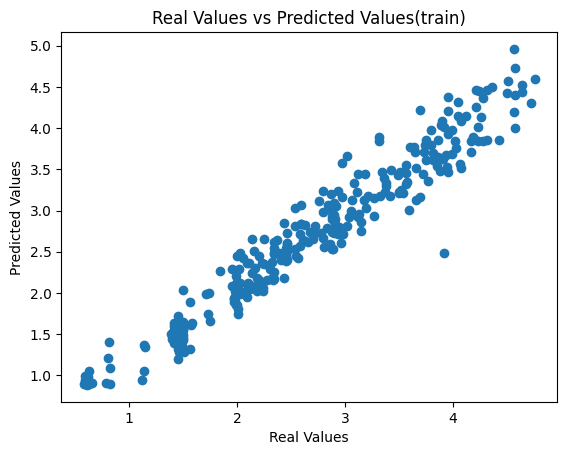

Train loss 0.0624692824203521
train acc 0.684375
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/dri

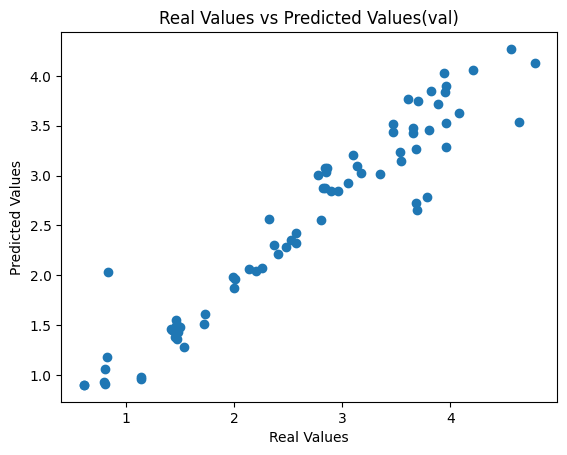

Val loss 0.11318388339132071
val acc 0.7625
Epoch 50/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_3.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_1.jpg
/content/drive/MyDrive/olive/segmented/md1_6.jpg
/content/drive/MyDrive/olive/segmented/md3_3_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_3.jpg
/content/drive/MyDrive/olive/segmented/im1_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_5.jpg
/content/drive/MyDrive/olive/segmented/md3_2.jpg
/content/drive/MyDrive/olive/segmented/O_124141.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_3.jp

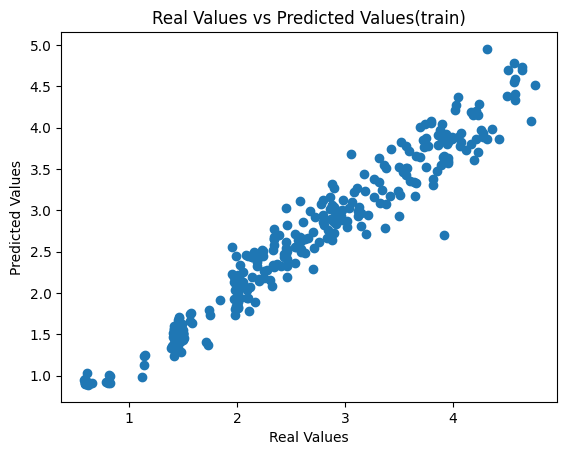

Train loss 0.056638529465999454
train acc 0.7
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/conten

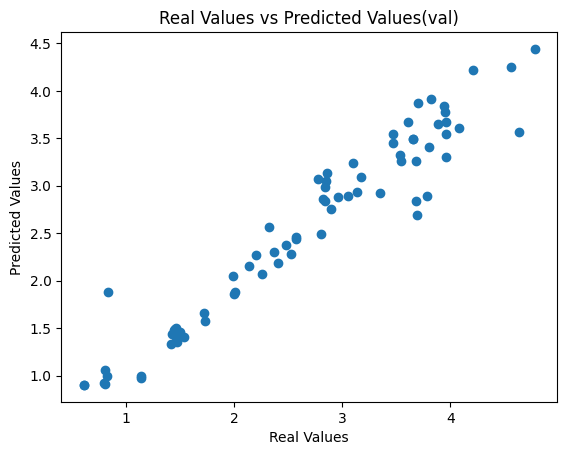

Val loss 0.09794405028223992
val acc 0.7375
Epoch 51/60
----------
/content/drive/MyDrive/olive/segmented/md4_5_9_flip_6.jpg
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_3.jpg
/content/drive/MyDrive/olive/segmented/im14.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/md1_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/md7_2_6.jpg
/content/drive/MyDrive/olive/segmented/O_124141_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_3.jpg
/content/drive/MyDrive/olive/segmented/I

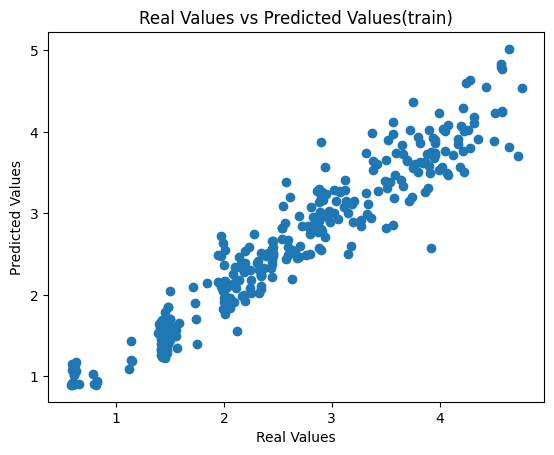

Train loss 0.09308490576222539
train acc 0.646875
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive

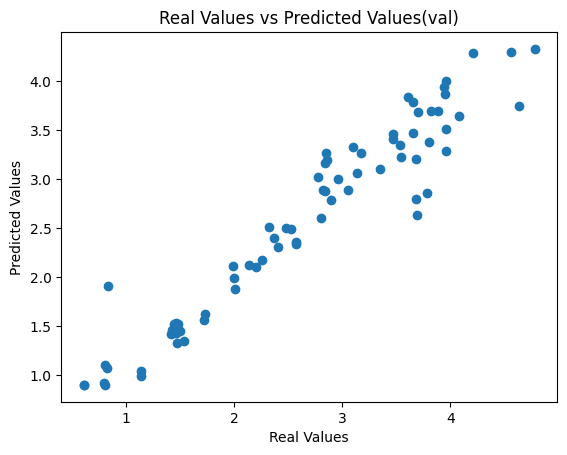

Val loss 0.09884029291570187
val acc 0.75
Epoch 52/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_5.jpg
/content/drive/MyDrive/olive/segmented/im9_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_1.jpg
/content/drive/MyDrive/olive/segmented/im7_2.jpg
/content/drive/MyDrive/olive/segmented/im10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/im3_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_122127.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_7.jpg
/content/drive/MyDrive/ol

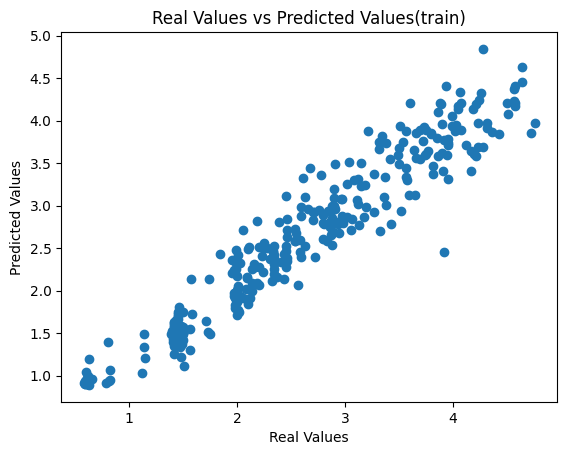

Train loss 0.08771513593383133
train acc 0.621875
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/conte

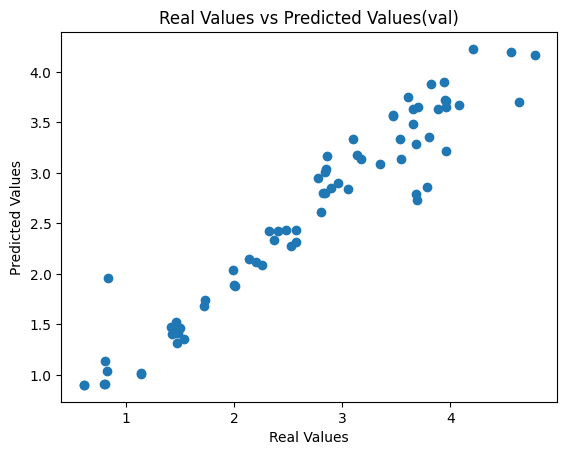

Val loss 0.09898296073079109
val acc 0.7375
Epoch 53/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_3.jpg
/content/drive/MyDrive/olive/segmented/O_124141_5.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_2.jpg
/content/drive/MyDrive/olive/segmented/O_130123_1.jpg
/content/drive/MyDrive/olive/segmented/im1_2.jpg
/content/drive/MyDrive/olive/segmented/md1_10.jpg
/content/drive/MyDrive/olive/segmented/O_125721_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_1.jpg
/content/drive/MyDrive/ol

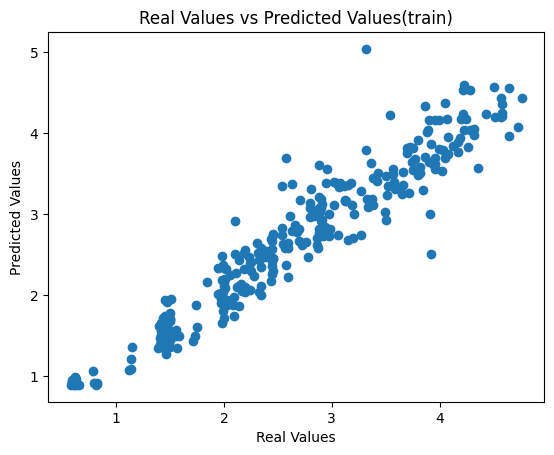

Train loss 0.08925928012467921
train acc 0.621875
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/seg

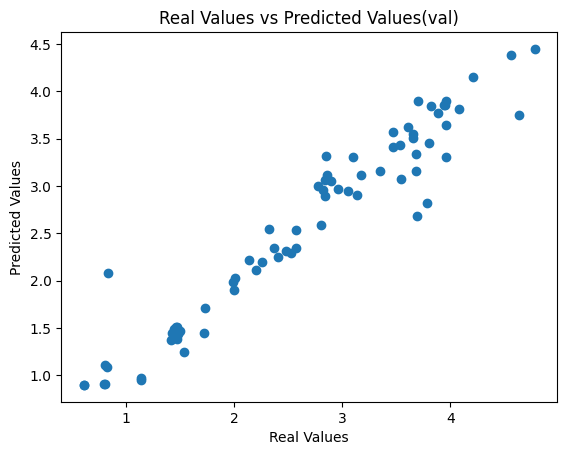

Val loss 0.091381711140275
val acc 0.75
Epoch 54/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_7.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/im8_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_1.jpg
/content/drive/MyDrive/olive/segmented/im5_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_5.jpg
/content/drive/MyDrive/olive/segmented/im1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_10.jpg
/content/drive/MyDrive/oli

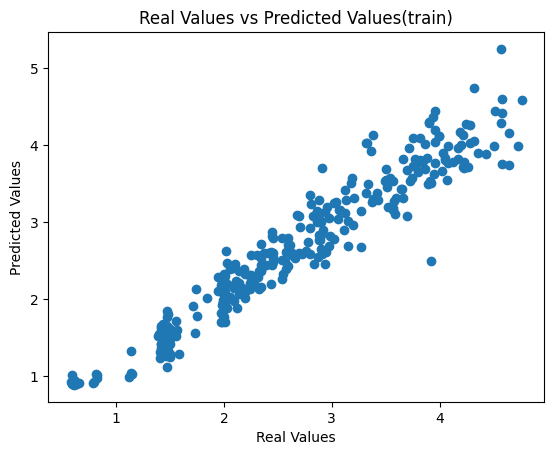

Train loss 0.07715371113736183
train acc 0.665625
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.

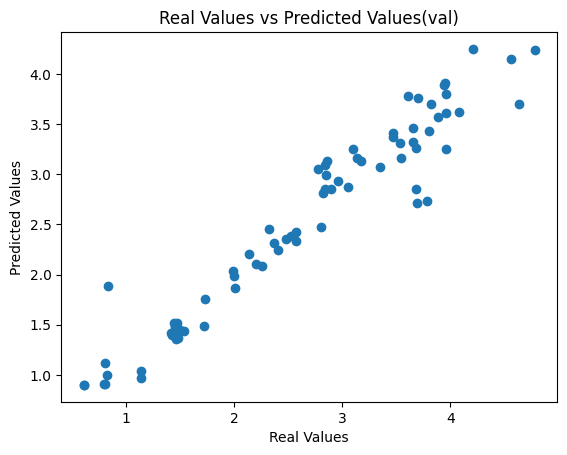

Val loss 0.10047628385946154
val acc 0.7125
Epoch 55/60
----------
/content/drive/MyDrive/olive/segmented/im5_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_1.jpg
/content/drive/MyDrive/olive/segmented/md7_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_2.jpg
/content/drive/MyDrive/olive/segmented/md1_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/O_124141_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/im13_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210

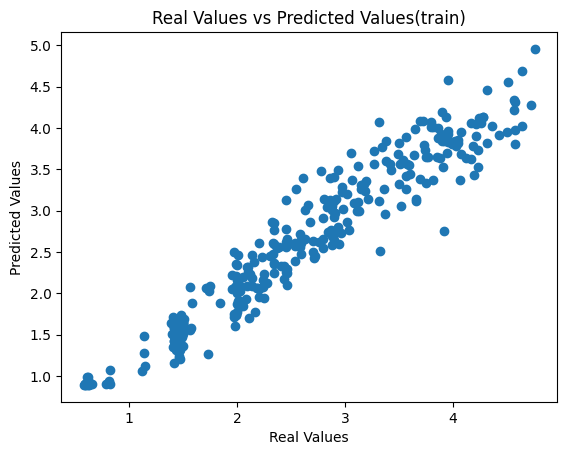

Train loss 0.08151497701182961
train acc 0.6375
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/

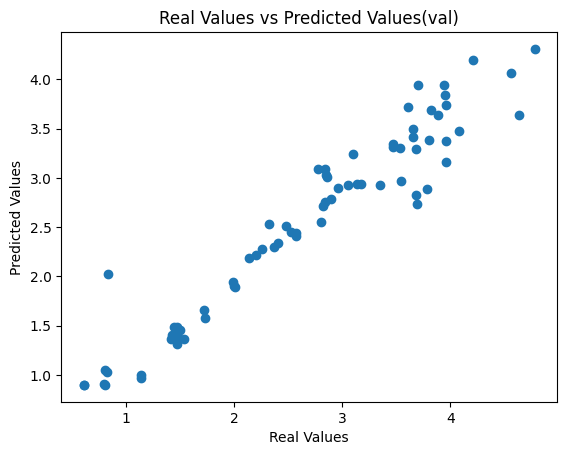

Val loss 0.11192676611244678
val acc 0.775
Epoch 56/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427.jpg
/content/drive/MyDrive/olive/segmented/im1_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_flip_6.jpg
/content/drive/MyDrive/olive/segmented/md7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_3.jpg
/content/drive/MyDrive/olive/segmented/im8_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_2.jpg
/content/drive/MyDrive/olive/segmented/im14_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_1.jpg
/content/drive/MyDrive/olive/segmen

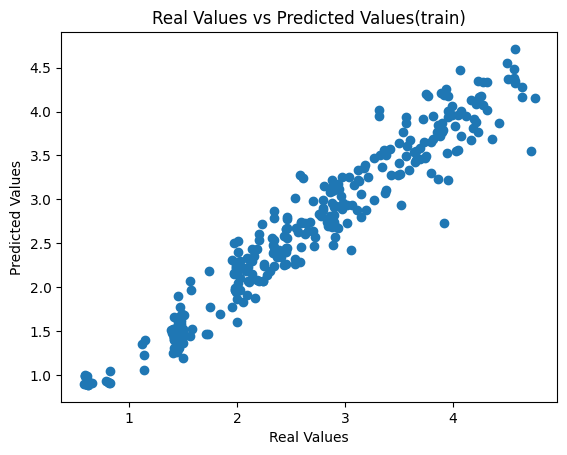

Train loss 0.06996995867229998
train acc 0.7
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im14_5_f

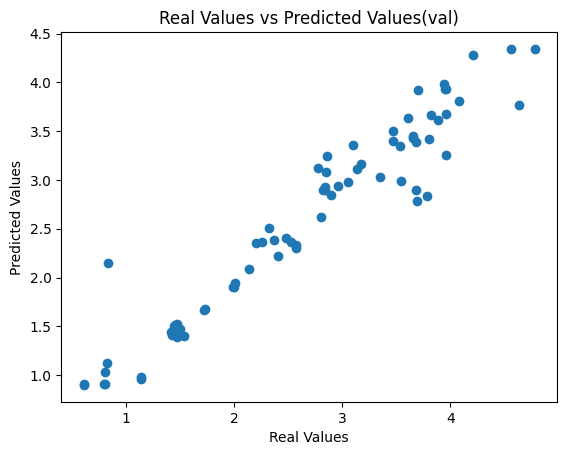

Val loss 0.09723279494792222
val acc 0.7375
Epoch 57/60
----------
/content/drive/MyDrive/olive/segmented/im1_3.jpg
/content/drive/MyDrive/olive/segmented/md2_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_3.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_2.jpg
/content/drive/MyDrive/olive/segmented/md2_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_1.jpg
/content/drive/MyDrive/olive/segmented/im9_2.jpg
/content/drive/MyDrive/olive/segmented/im14.jpg
/content/drive/MyDrive/olive/segmented/im5_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_8.jpg
/content/drive/My

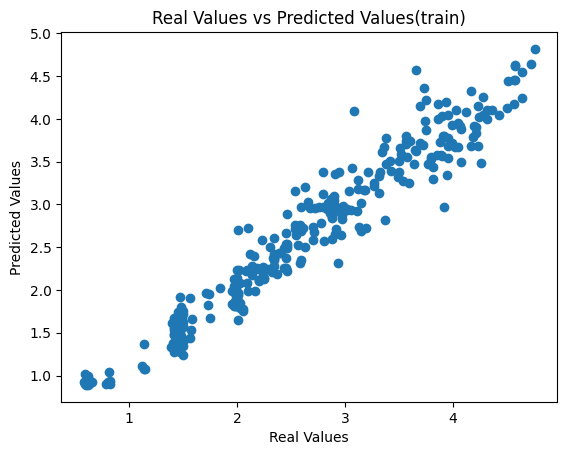

Train loss 0.06303995086345822
train acc 0.70625
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/im14_4.jpg
/content/drive/MyDrive/o

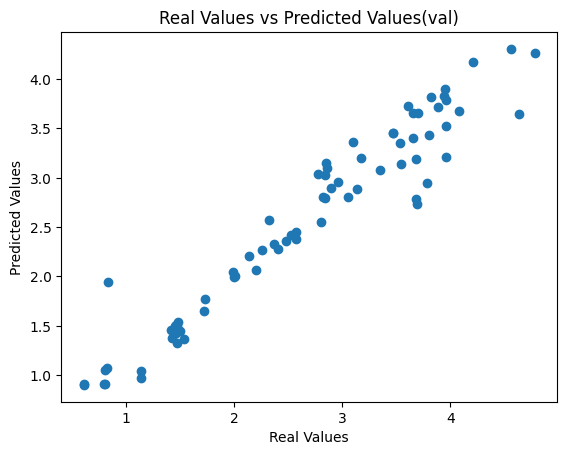

Val loss 0.09700614884495735
val acc 0.7375
Epoch 58/60
----------
/content/drive/MyDrive/olive/segmented/im3_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_9.jpg
/content/drive/MyDrive/olive/segmented/im7_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_4.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_8.jpg
/content/drive/MyDrive/olive/segmented/im12_2_flip_6.jpg
/content/drive/MyDrive/olive/segmented/md7_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_8.jpg
/content/drive/MyDrive/olive/segmented/O_125721_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_2.jp

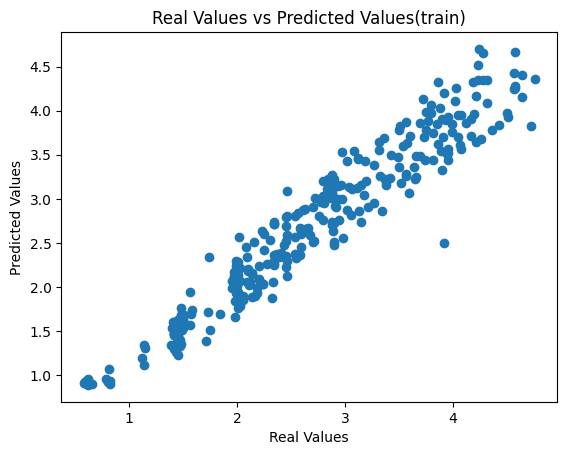

Train loss 0.0710843903478235
train acc 0.653125
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmente

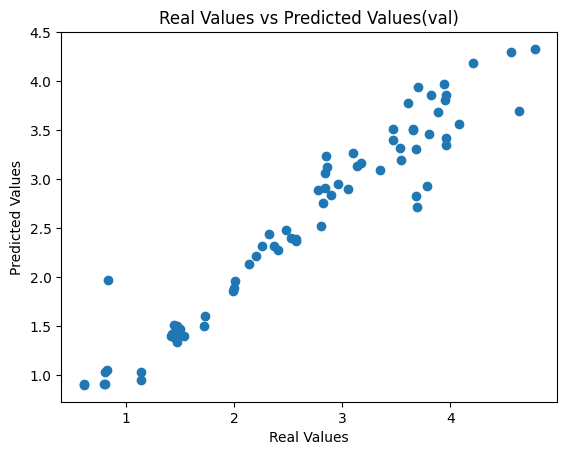

Val loss 0.09389685466885567
val acc 0.7625
Epoch 59/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_translation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_5.jpg
/content/drive/MyDrive/olive/segmented/im11_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_1.jpg
/content/drive/MyDrive/olive/segmented/md1_4_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_5.jpg
/content/drive/MyDrive/olive/segmented/md7.jpg
/content/drive/MyDrive/olive/segmented/im8_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_8.jpg
/content/drive/MyDrive/

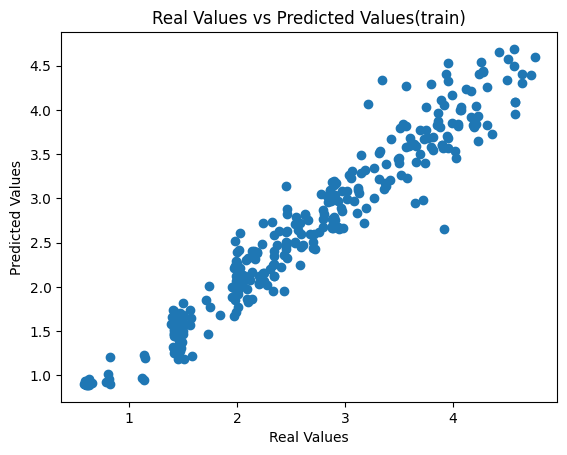

Train loss 0.06789810524787754
train acc 0.675
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220

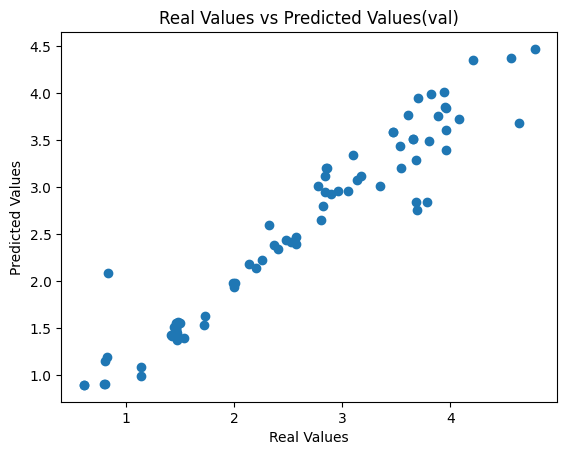

Val loss 0.09472438544034958
val acc 0.7375
Epoch 60/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_1.jpg
/content/drive/MyDrive/olive/segmented/md2_2_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_2.jpg
/content/drive/MyDrive/olive/segmented/md2_1_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_6.jpg
/content/drive/MyDrive/olive/segmented/md2_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_7.jpg
/content/drive/MyDrive/olive/se

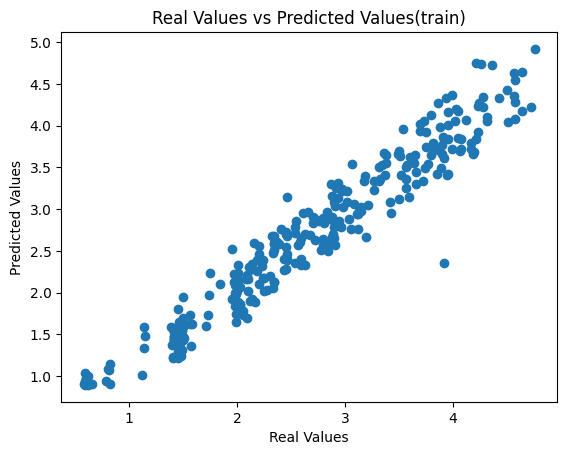

Train loss 0.0653965736622922
train acc 0.675
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_4.jpg
/conte

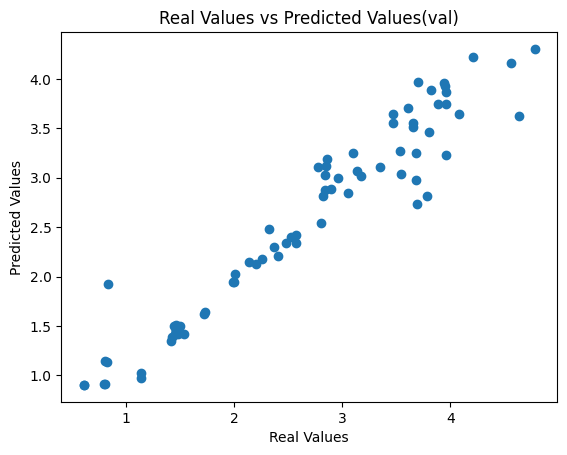

Val loss 0.09679803727194666
val acc 0.725


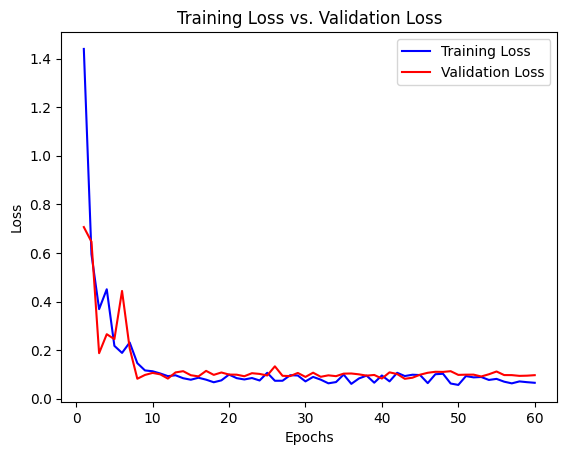

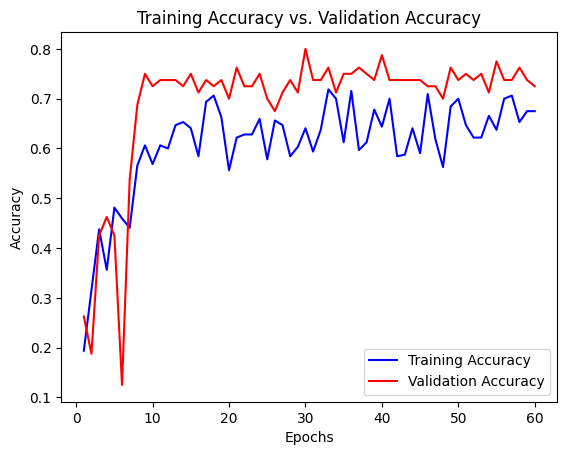

best_accuracy:  0.8
best_train_loss:  0.07116878784727305
best_test_loss:  0.08960105860605835


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model18, history18 = train_model(model18, device)
